# Credit Default Prediction - Amex Competition

This notebook implements the analysis steps for the Amex Default Prediction competition.

## Project Overview
- **Data Source**: [Kaggle Amex Default Prediction](https://www.kaggle.com/competitions/amex-default-prediction/data)
- **Objective**: Predict credit default status of customers
- **Target Variable**: Default status as of April 2018 (from train_labels.csv)

## Step 1: Import Required Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Set plot style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print("Libraries imported successfully!")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")

Libraries imported successfully!
Pandas version: 2.2.3
NumPy version: 1.26.4


## Step 2: Define File Paths

In [5]:
# Define file paths
TRAIN_DATA_PATH = 'train_data.csv'
TRAIN_LABELS_PATH = 'train_labels.csv'
SAMPLE_DATA_PATH = 'train_data_sample.csv'

print("File paths configured:")
print(f"  Train Data: {TRAIN_DATA_PATH}")
print(f"  Train Labels: {TRAIN_LABELS_PATH}")
print(f"  Sample Data (output): {SAMPLE_DATA_PATH}")

File paths configured:
  Train Data: train_data.csv
  Train Labels: train_labels.csv
  Sample Data (output): train_data_sample.csv


## Step 3: Load Train Labels (Quick Preview)

Let's first load the labels file to understand the target variable.

In [ ]:
# Load train labels
print("Loading train_labels.csv...")
train_labels = pd.read_csv(TRAIN_LABELS_PATH)

print(f"\nLabels shape: {train_labels.shape}")
print(f"\nFirst few rows:")
display(train_labels.head(10))

print(f"\nLabel distribution:")
print(train_labels['target'].value_counts())
print(f"\nDefault rate: {train_labels['target'].mean():.2%}")

## Step 4: Create 20% Sample from Train Data

⚠️ **Important**: Due to the large size of train_data.csv (~16GB), we'll create a 20% sample to work with.

This approach:
- Reads the data in chunks to avoid memory errors
- Randomly samples 20% of observations from train_labels.csv
- Filters train_data.csv to include only the sampled customer IDs
- Saves the sample for future use

In [ ]:
# Step 4.1: Sample 20% of customer IDs from labels
print("Step 4.1: Sampling 20% of customer IDs...")
np.random.seed(42)  # For reproducibility

# Sample 20% of customer IDs
sample_labels = train_labels.sample(frac=0.20, random_state=42)
sample_customer_ids = set(sample_labels['customer_ID'].values)

print(f"Total customers in full dataset: {len(train_labels):,}")
print(f"Sampled customers (20%): {len(sample_customer_ids):,}")
print(f"\nSample label distribution:")
print(sample_labels['target'].value_counts())
print(f"Sample default rate: {sample_labels['target'].mean():.2%}")

In [ ]:
# Step 4.2: Read train_data.csv in chunks and filter for sampled customers
print("\nStep 4.2: Reading train_data.csv in chunks and filtering...")
print("This may take several minutes due to the large file size...\n")

chunk_size = 1_000_000  # Process 1 million rows at a time
sample_data_chunks = []
total_rows_processed = 0
total_rows_kept = 0

start_time = datetime.now()

# Read and filter in chunks
for i, chunk in enumerate(pd.read_csv(TRAIN_DATA_PATH, chunksize=chunk_size)):
    # Filter chunk for sampled customer IDs
    filtered_chunk = chunk[chunk['customer_ID'].isin(sample_customer_ids)]
    sample_data_chunks.append(filtered_chunk)
    
    total_rows_processed += len(chunk)
    total_rows_kept += len(filtered_chunk)
    
    # Progress update every 5 chunks
    if (i + 1) % 5 == 0:
        elapsed = (datetime.now() - start_time).total_seconds()
        print(f"Processed chunk {i+1}: {total_rows_processed:,} rows scanned, "
              f"{total_rows_kept:,} rows kept ({elapsed:.1f}s elapsed)")

print(f"\n✓ Finished processing all chunks!")
print(f"Total rows scanned: {total_rows_processed:,}")
print(f"Total rows kept in sample: {total_rows_kept:,}")
print(f"Reduction: {(1 - total_rows_kept/total_rows_processed)*100:.1f}%")

In [ ]:
# Step 4.3: Combine chunks and save sample
print("\nStep 4.3: Combining chunks and saving sample...")

# Concatenate all filtered chunks
train_data_sample = pd.concat(sample_data_chunks, ignore_index=True)

print(f"Sample data shape: {train_data_sample.shape}")
print(f"Unique customers in sample: {train_data_sample['customer_ID'].nunique():,}")

# Save the sample
print(f"\nSaving sample to {SAMPLE_DATA_PATH}...")
train_data_sample.to_csv(SAMPLE_DATA_PATH, index=False)

# Also save the sampled labels
sample_labels.to_csv('train_labels_sample.csv', index=False)

print("\n✓ Sample data saved successfully!")
print(f"  - {SAMPLE_DATA_PATH}")
print(f"  - train_labels_sample.csv")

# Calculate file size reduction
import os
original_size = os.path.getsize(TRAIN_DATA_PATH) / (1024**3)  # GB
sample_size = os.path.getsize(SAMPLE_DATA_PATH) / (1024**3)  # GB
print(f"\nFile size comparison:")
print(f"  Original: {original_size:.2f} GB")
print(f"  Sample: {sample_size:.2f} GB")
print(f"  Reduction: {((original_size - sample_size) / original_size * 100):.1f}%")

In [52]:
cols = [col for col in list(train_data_sample.columns) if col not in ['customer_ID',"target"]]
# Get the first letter of each column name
first_letters = [col[0] for col in cols]

# Count the number of columns for each letter
letter_counts = pd.Series(first_letters).value_counts().reset_index()
letter_counts.columns = ["Variable Types","No of Features"]
letter_counts["Letter"] = ["Delinquency variables","Balance variables","Risk variables","Spend variables","Payment variables"]

letter_counts

,Variable Types,No of Features,Letter
0,D,96,Delinquency variables
1,B,40,Balance variables
2,R,28,Risk variables
3,S,22,Spend variables
4,P,3,Payment variables


## Summary of Step 4

✅ **Completed Tasks:**
1. Loaded train_labels.csv to understand the target variable
2. Randomly sampled 20% of customer IDs (with seed=42 for reproducibility)
3. Read train_data.csv in chunks to avoid memory errors
4. Filtered and kept only rows for sampled customers
5. Saved the sample as `train_data_sample.csv` for future use

**Next Steps:**
- You can now work with `train_data_sample.csv` instead of the full dataset
- This avoids memory errors while maintaining representative data
- The sample preserves the original default rate distribution

---

## Step 5: One-Hot Encoding for Categorical Variables

In [6]:
# Load sample data if not already loaded
if 'train_data_sample' not in locals():
    train_data_sample = pd.read_csv(SAMPLE_DATA_PATH)
    print(f"Loaded sample data: {train_data_sample.shape}")

Loaded sample data: (1107082, 190)


In [7]:
from sklearn.preprocessing import OneHotEncoder

# Define the categorical columns to encode
categorical_cols = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']

# Create a copy of the original DataFrame
train_data_sample_copy = train_data_sample.copy()

# Initialize OneHotEncoder with drop='first' to avoid dummy variable trap
encoder = OneHotEncoder(drop='first', sparse_output=False)

# Fit and transform the categorical columns
encoded_values = encoder.fit_transform(train_data_sample_copy[categorical_cols])

# Create a DataFrame with the encoded column names
encoded_df = pd.DataFrame(encoded_values, columns=encoder.get_feature_names_out(categorical_cols), index=train_data_sample_copy.index)

# Drop original categorical columns and concatenate the encoded DataFrame
train_data_sample_encoded = pd.concat([train_data_sample_copy.drop(columns=categorical_cols), encoded_df], axis=1)

# Display the shape and first few rows of the final DataFrame
print("Shape after One-Hot Encoding:", train_data_sample_encoded.shape)
print(train_data_sample_encoded.head())

Shape after One-Hot Encoding: (1107082, 223)
                                         customer_ID         S_2       P_2  \
0  000098081fde4fd64bc4d503a5d6f86a0aedc425c96f52...  2017-03-11  0.374606   
1  000098081fde4fd64bc4d503a5d6f86a0aedc425c96f52...  2017-04-22  0.414269   
2  000098081fde4fd64bc4d503a5d6f86a0aedc425c96f52...  2017-05-12  0.413310   
3  000098081fde4fd64bc4d503a5d6f86a0aedc425c96f52...  2017-06-10  0.328983   
4  000098081fde4fd64bc4d503a5d6f86a0aedc425c96f52...  2017-07-19  0.496989   

       D_39       B_1       B_2       R_1       S_3      D_41       B_3  \
0  0.033519  0.044293  1.008622  0.001470  0.459235  0.002339  0.006168   
1  0.002516  0.059667  0.123964  0.004374  0.434148  0.001405  0.052130   
2  0.003285  0.053418  0.304955  0.002316  0.415906  0.009388  0.048780   
3  0.038574  0.049463  0.115654  0.004654  0.416112  0.003223  0.081001   
4  0.005552  0.041452  0.133631  0.007363  0.419864  0.003393  0.098308   

       D_42      D_43      D_44    

In [8]:
print(train_data_sample_encoded.columns)

Index(['customer_ID', 'S_2', 'P_2', 'D_39', 'B_1', 'B_2', 'R_1', 'S_3', 'D_41',
       'B_3',
       ...
       'D_64_nan', 'D_66_1.0', 'D_66_nan', 'D_68_1.0', 'D_68_2.0', 'D_68_3.0',
       'D_68_4.0', 'D_68_5.0', 'D_68_6.0', 'D_68_nan'],
      dtype='object', length=223)


In [9]:
encoded_df

,B_30_1.0,B_30_2.0,B_30_nan,B_38_2.0,B_38_3.0,B_38_4.0,B_38_5.0,B_38_6.0,B_38_7.0,B_38_nan,D_114_1.0,D_114_nan,D_116_1.0,D_116_nan,D_117_1.0,D_117_2.0,D_117_3.0,D_117_4.0,D_117_5.0,D_117_6.0,D_117_nan,D_120_1.0,D_120_nan,D_126_0.0,D_126_1.0,D_126_nan,D_63_CO,D_63_CR,D_63_XL,D_63_XM,D_63_XZ,D_64_O,D_64_R,D_64_U,D_64_nan,D_66_1.0,D_66_nan,D_68_1.0,D_68_2.0,D_68_3.0,D_68_4.0,D_68_5.0,D_68_6.0,D_68_nan
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1107077,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1107078,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1107079,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1107080,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [10]:
df = pd.DataFrame()
df["Features"] = categorical_cols
t = list()
l = 0 
null_count = 0
for col in categorical_cols:
    l = l + len(train_data_sample[col].value_counts())
    t.append(list(train_data_sample[col].unique()))
    if train_data_sample[col].isna().sum() > 0:
        null_count = null_count + 1
        
print("total no of category values combined in all category variables is: " + str(l))
print("total no of Null variables is: " + str(null_count))
print("Total no of columns to be added after OHE is: " + str(l + null_count))
print("Total Columns in original Data Frame: " + str(len(train_data_sample.columns)))
print("Total Columns after OHE is: " + str(len(train_data_sample_encoded.columns)))
df["n_uniques"] = t
df

total no of category values combined in all category variables is: 45
total no of Null variables is: 10
Total no of columns to be added after OHE is: 55
Total Columns in original Data Frame: 190
Total Columns after OHE is: 223


,Features,n_uniques
0,B_30,"[0.0, 2.0, 1.0, nan]"
1,B_38,"[1.0, 5.0, 3.0, 2.0, 6.0, 7.0, 4.0, nan]"
2,D_114,"[nan, 0.0, 1.0]"
3,D_116,"[nan, 0.0, 1.0]"
4,D_117,"[nan, 2.0, -1.0, 4.0, 3.0, 1.0, 6.0, 5.0]"
5,D_120,"[nan, 0.0, 1.0]"
6,D_126,"[nan, 0.0, 1.0, -1.0]"
7,D_63,"[CO, CL, CR, XL, XM, XZ]"
8,D_64,"[nan, R, O, U, -1]"
9,D_66,"[nan, 1.0, 0.0]"


---

## Step 6: Feature Aggregation by Customer ID

Aggregate numerical and categorical features for each customer.

**Note**: Each customer has historical data for up to 13 months. We need to aggregate this time-series data into single features per customer.

In [11]:
# Load encoded data if not already loaded
if 'train_data_sample_encoded' not in locals():
    print("Loading encoded data...")
    train_data_sample_encoded = pd.read_csv('train_data_sample_encoded.csv')
    print(f"Loaded! Shape: {train_data_sample_encoded.shape}")

# Load labels
if 'sample_labels' not in locals():
    sample_labels = pd.read_csv('train_labels_sample.csv')
    print(f"Loaded labels! Shape: {sample_labels.shape}")

Loaded labels! Shape: (91783, 2)


### 6.1: Analyze Data Structure

First, let's understand how many months of data each customer has.

In [ ]:
# Count observations per customer
customer_counts = train_data_sample_encoded.groupby('customer_ID').size().reset_index(name='observations')
customer_counts['months_of_data'] = customer_counts['observations']

# Merge with labels to get default rate
customer_summary = customer_counts.merge(sample_labels, on='customer_ID', how='left')

# Create summary table by months of data
summary_table = customer_summary.groupby('months_of_data').agg(
    observations=('customer_ID', 'count'),
    default_rate=('target', 'mean')
).reset_index()

# Add "All Applications" row
all_apps = pd.DataFrame([{
    'months_of_data': 'All Applications',
    'observations': len(customer_summary),
    'default_rate': customer_summary['target'].mean()
}])

summary_table = pd.concat([all_apps, summary_table], ignore_index=True)


# Display as formatted table
display(summary_table)


,months_of_data,observations,default_rate
0,All Applications,91783,0.256507
1,1,984,0.331301
2,2,1217,0.312243
3,3,1158,0.357513
4,4,938,0.430704
5,5,933,0.394427
6,6,1109,0.412985
7,7,1046,0.414914
8,8,1169,0.450813
9,9,1278,0.435837


### 6.2: Define Numerical and Categorical Features

In [39]:
# Identify numerical and categorical columns
# Exclude customer_ID and S_2 (date)
exclude_cols = ['customer_ID', 'S_2']

# Original categorical column names (before one-hot encoding)
original_categorical_cols = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']

# One-hot encoded columns start with the original categorical column names followed by underscore
categorical_encoded_cols = [col for col in train_data_sample_encoded.columns 
                           if any(col.startswith(cat + '_') for cat in original_categorical_cols)]

# Numerical columns are the rest (excluding customer_ID and S_2)
numerical_cols = [col for col in train_data_sample_encoded.columns 
                 if col not in exclude_cols and col not in categorical_encoded_cols]

print(f"Total columns: {len(train_data_sample_encoded.columns)}")
print(f"Numerical features: {len(numerical_cols)}")
print(f"Categorical encoded features: {len(categorical_encoded_cols)}")
print(f"\nFirst 10 numerical features: {numerical_cols[:10]}")
print(f"\nFirst 10 categorical features: {categorical_encoded_cols[:10]}")

Total columns: 223
Numerical features: 177
Categorical encoded features: 44

First 10 numerical features: ['P_2', 'D_39', 'B_1', 'B_2', 'R_1', 'S_3', 'D_41', 'B_3', 'D_42', 'D_43']

First 10 categorical features: ['B_30_1.0', 'B_30_2.0', 'B_30_nan', 'B_38_2.0', 'B_38_3.0', 'B_38_4.0', 'B_38_5.0', 'B_38_6.0', 'B_38_7.0', 'B_38_nan']


### 6.3: Aggregate Numerical Features

For numerical features, we'll calculate:
- **Average** (mean)
- **Sum**
- **Min** (minimum)
- **Max** (maximum)
- **Last** (most recent value)

In [40]:
print("Aggregating numerical features...")
print("This may take a few minutes...\n")

# Define aggregation functions for numerical features
agg_functions = {
    'mean': 'mean',
    'sum': 'sum',
    'min': 'min',
    'max': 'max',
    'last': 'last'
}

# Create aggregation dictionary for all numerical columns
agg_dict = {col: list(agg_functions.values()) for col in numerical_cols}

# Perform aggregation
numerical_agg = train_data_sample_encoded.groupby('customer_ID')[numerical_cols].agg(agg_dict)

# Flatten column names
numerical_agg.columns = ['_'.join(col).strip() for col in numerical_agg.columns.values]

# Reset index
numerical_agg = numerical_agg.reset_index()

print(f"✓ Numerical aggregation complete!")
print(f"  Shape: {numerical_agg.shape}")
print(f"  Customers: {len(numerical_agg)}")
print(f"  Features: {numerical_agg.shape[1] - 1}")

# Show sample
print("\nSample of aggregated numerical features:")
display(numerical_agg.head())

Aggregating numerical features...
This may take a few minutes...

✓ Numerical aggregation complete!
  Shape: (91783, 886)
  Customers: 91783
  Features: 885

Sample of aggregated numerical features:


,customer_ID,P_2_mean,P_2_sum,P_2_min,P_2_max,P_2_last,D_39_mean,D_39_sum,D_39_min,D_39_max,D_39_last,B_1_mean,B_1_sum,B_1_min,B_1_max,B_1_last,B_2_mean,B_2_sum,B_2_min,B_2_max,B_2_last,R_1_mean,R_1_sum,R_1_min,R_1_max,R_1_last,S_3_mean,S_3_sum,S_3_min,S_3_max,S_3_last,D_41_mean,D_41_sum,D_41_min,D_41_max,D_41_last,B_3_mean,B_3_sum,B_3_min,B_3_max,B_3_last,D_42_mean,D_42_sum,D_42_min,D_42_max,D_42_last,D_43_mean,D_43_sum,D_43_min,D_43_max,D_43_last,D_44_mean,D_44_sum,D_44_min,D_44_max,D_44_last,B_4_mean,B_4_sum,B_4_min,B_4_max,B_4_last,D_45_mean,D_45_sum,D_45_min,D_45_max,D_45_last,B_5_mean,B_5_sum,B_5_min,B_5_max,B_5_last,R_2_mean,R_2_sum,R_2_min,R_2_max,R_2_last,D_46_mean,D_46_sum,D_46_min,D_46_max,D_46_last,D_47_mean,D_47_sum,D_47_min,D_47_max,D_47_last,D_48_mean,D_48_sum,D_48_min,D_48_max,D_48_last,D_49_mean,D_49_sum,D_49_min,D_49_max,D_49_last,B_6_mean,B_6_sum,B_6_min,B_6_max,B_6_last,B_7_mean,B_7_sum,B_7_min,B_7_max,B_7_last,B_8_mean,B_8_sum,B_8_min,B_8_max,B_8_last,D_50_mean,D_50_sum,D_50_min,D_50_max,D_50_last,D_51_mean,D_51_sum,D_51_min,D_51_max,D_51_last,B_9_mean,B_9_sum,B_9_min,B_9_max,B_9_last,R_3_mean,R_3_sum,R_3_min,R_3_max,R_3_last,D_52_mean,D_52_sum,D_52_min,D_52_max,D_52_last,P_3_mean,P_3_sum,P_3_min,P_3_max,P_3_last,B_10_mean,B_10_sum,B_10_min,B_10_max,B_10_last,D_53_mean,D_53_sum,D_53_min,D_53_max,D_53_last,S_5_mean,S_5_sum,S_5_min,S_5_max,S_5_last,B_11_mean,B_11_sum,B_11_min,B_11_max,B_11_last,S_6_mean,S_6_sum,S_6_min,S_6_max,S_6_last,D_54_mean,D_54_sum,D_54_min,D_54_max,D_54_last,R_4_mean,R_4_sum,R_4_min,R_4_max,R_4_last,S_7_mean,S_7_sum,S_7_min,S_7_max,S_7_last,B_12_mean,B_12_sum,B_12_min,B_12_max,B_12_last,S_8_mean,S_8_sum,S_8_min,S_8_max,S_8_last,D_55_mean,D_55_sum,D_55_min,D_55_max,D_55_last,D_56_mean,D_56_sum,D_56_min,D_56_max,D_56_last,B_13_mean,B_13_sum,B_13_min,B_13_max,B_13_last,R_5_mean,R_5_sum,R_5_min,R_5_max,R_5_last,D_58_mean,D_58_sum,D_58_min,D_58_max,D_58_last,S_9_mean,S_9_sum,S_9_min,S_9_max,S_9_last,B_14_mean,B_14_sum,B_14_min,B_14_max,B_14_last,D_59_mean,D_59_sum,D_59_min,D_59_max,D_59_last,D_60_mean,D_60_sum,D_60_min,D_60_max,D_60_last,D_61_mean,D_61_sum,D_61_min,D_61_max,D_61_last,B_15_mean,B_15_sum,B_15_min,B_15_max,B_15_last,S_11_mean,S_11_sum,S_11_min,S_11_max,S_11_last,D_62_mean,D_62_sum,D_62_min,D_62_max,D_62_last,D_65_mean,D_65_sum,D_65_min,D_65_max,D_65_last,B_16_mean,B_16_sum,B_16_min,B_16_max,B_16_last,B_17_mean,B_17_sum,B_17_min,B_17_max,B_17_last,B_18_mean,B_18_sum,B_18_min,B_18_max,B_18_last,B_19_mean,B_19_sum,B_19_min,B_19_max,B_19_last,B_20_mean,B_20_sum,B_20_min,B_20_max,B_20_last,S_12_mean,S_12_sum,S_12_min,S_12_max,S_12_last,R_6_mean,R_6_sum,R_6_min,R_6_max,R_6_last,S_13_mean,S_13_sum,S_13_min,S_13_max,S_13_last,B_21_mean,B_21_sum,B_21_min,B_21_max,B_21_last,D_69_mean,D_69_sum,D_69_min,D_69_max,D_69_last,B_22_mean,B_22_sum,B_22_min,B_22_max,B_22_last,D_70_mean,D_70_sum,D_70_min,D_70_max,D_70_last,D_71_mean,D_71_sum,D_71_min,D_71_max,D_71_last,D_72_mean,D_72_sum,D_72_min,D_72_max,D_72_last,S_15_mean,S_15_sum,S_15_min,S_15_max,S_15_last,B_23_mean,B_23_sum,B_23_min,B_23_max,B_23_last,D_73_mean,D_73_sum,D_73_min,D_73_max,D_73_last,P_4_mean,P_4_sum,P_4_min,P_4_max,P_4_last,D_74_mean,D_74_sum,D_74_min,D_74_max,D_74_last,D_75_mean,D_75_sum,D_75_min,D_75_max,D_75_last,D_76_mean,D_76_sum,D_76_min,D_76_max,D_76_last,B_24_mean,B_24_sum,B_24_min,B_24_max,B_24_last,R_7_mean,R_7_sum,R_7_min,R_7_max,R_7_last,D_77_mean,D_77_sum,D_77_min,D_77_max,D_77_last,B_25_mean,B_25_sum,B_25_min,B_25_max,B_25_last,B_26_mean,B_26_sum,B_26_min,B_26_max,B_26_last,D_78_mean,D_78_sum,D_78_min,D_78_max,D_78_last,D_79_mean,D_79_sum,D_79_min,D_79_max,D_79_last,R_8_mean,R_8_sum,R_8_min,R_8_max,R_8_last,R_9_mean,R_9_sum,R_9_min,R_9_max,R_9_last,S_16_mean,S_16_sum,S_16_min,S_16_max,S_16_last,D_80_mean,D_80_sum,D_80_min,D_80_max,D_80_last,R_10_mean,R_10_sum,R_10_min,R_10_max,R_10_last,R_11_mean,R_11_sum,R_11_min,R_11_max,R_11_last,B_27_mean,B_27_sum,B_27_min,B_27_max,B_27_last,D_81_mean,D_81_sum,D_81_min,D_81_

### 6.4: Aggregate Categorical Features

For categorical (one-hot encoded) features, we'll calculate:
- **Sum** (count of times the category appeared)
- **Mean** (percentage of times the category appeared)

In [41]:
print("Aggregating categorical features...")
print("This may take a few minutes...\n")

# For categorical features, use sum and mean
cat_agg_dict = {col: ['sum', 'mean'] for col in categorical_encoded_cols}

# Perform aggregation
categorical_agg = train_data_sample_encoded.groupby('customer_ID')[categorical_encoded_cols].agg(cat_agg_dict)

# Flatten column names
categorical_agg.columns = ['_'.join(col).strip() for col in categorical_agg.columns.values]

# Reset index
categorical_agg = categorical_agg.reset_index()

print(f"✓ Categorical aggregation complete!")
print(f"  Shape: {categorical_agg.shape}")
print(f"  Customers: {len(categorical_agg)}")
print(f"  Features: {categorical_agg.shape[1] - 1}")

# Show sample
print("\nSample of aggregated categorical features:")
display(categorical_agg.head())

Aggregating categorical features...
This may take a few minutes...

✓ Categorical aggregation complete!
  Shape: (91783, 89)
  Customers: 91783
  Features: 88

Sample of aggregated categorical features:


,customer_ID,B_30_1.0_sum,B_30_1.0_mean,B_30_2.0_sum,B_30_2.0_mean,B_30_nan_sum,B_30_nan_mean,B_38_2.0_sum,B_38_2.0_mean,B_38_3.0_sum,B_38_3.0_mean,B_38_4.0_sum,B_38_4.0_mean,B_38_5.0_sum,B_38_5.0_mean,B_38_6.0_sum,B_38_6.0_mean,B_38_7.0_sum,B_38_7.0_mean,B_38_nan_sum,B_38_nan_mean,D_114_1.0_sum,D_114_1.0_mean,D_114_nan_sum,D_114_nan_mean,D_116_1.0_sum,D_116_1.0_mean,D_116_nan_sum,D_116_nan_mean,D_117_1.0_sum,D_117_1.0_mean,D_117_2.0_sum,D_117_2.0_mean,D_117_3.0_sum,D_117_3.0_mean,D_117_4.0_sum,D_117_4.0_mean,D_117_5.0_sum,D_117_5.0_mean,D_117_6.0_sum,D_117_6.0_mean,D_117_nan_sum,D_117_nan_mean,D_120_1.0_sum,D_120_1.0_mean,D_120_nan_sum,D_120_nan_mean,D_126_0.0_sum,D_126_0.0_mean,D_126_1.0_sum,D_126_1.0_mean,D_126_nan_sum,D_126_nan_mean,D_63_CO_sum,D_63_CO_mean,D_63_CR_sum,D_63_CR_mean,D_63_XL_sum,D_63_XL_mean,D_63_XM_sum,D_63_XM_mean,D_63_XZ_sum,D_63_XZ_mean,D_64_O_sum,D_64_O_mean,D_64_R_sum,D_64_R_mean,D_64_U_sum,D_64_U_mean,D_64_nan_sum,D_64_nan_mean,D_66_1.0_sum,D_66_1.0_mean,D_66_nan_sum,D_66_nan_mean,D_68_1.0_sum,D_68_1.0_mean,D_68_2.0_sum,D_68_2.0_mean,D_68_3.0_sum,D_68_3.0_mean,D_68_4.0_sum,D_68_4.0_mean,D_68_5.0_sum,D_68_5.0_mean,D_68_6.0_sum,D_68_6.0_mean,D_68_nan_sum,D_68_nan_mean
0,000098081fde4fd64bc4d503a5d6f86a0aedc425c96f52...,1.0,0.076923,2.0,0.153846,0.0,0.0,0.0,0.000000,1.0,0.076923,0.0,0.0,5.0,0.384615,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,2.0,0.153846,0.0,0.0,2.0,0.153846,0.0,0.0,11.0,0.846154,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,2.0,0.153846,0.0,0.0,2.0,0.153846,11.0,0.846154,0.0,0.0,2.0,0.153846,13.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,11.0,0.846154,0.0,0.000000,2.0,0.153846,0.0,0.0,13.0,1.0,0.0,0.0,7.0,0.538462,4.0,0.307692,0.0,0.0,0.0,0.000000,0.0,0.000000,2.0,0.153846
1,000445609ff2a39d2dd02484899affa5696210a95f6869...,0.0,0.000000,0.0,0.000000,0.0,0.0,5.0,0.384615,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,13.0,1.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,1.0,0.076923,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,13.0,1.0,0.0,0.000000,13.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,1.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,13.0,1.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,13.0,1.000000,0.0,0.000000
2,0004837f0c785928a29a6f83f70f4a1c54caec483a773f...,7.0,0.538462,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,3.0,0.230769,10.0,0.769231,0.0,0.0,13.0,1.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,13.0,1.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,13.0,1.000000,0.0,0.000000,0.0,0.0,13.0,1.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,13.0,1.000000,0.0,0.000000,0.0,0.000000
3,0004ec03ca1ab2adb9aa260c61ba5dce8185e19d3ab704...,0.0,0.000000,0.0,0.000000,0.0,0.0,13.0,1.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,13.0,1.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,4.0,0.307692,8.0,0.615385,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,13.0,1.0,0.0,0.000000,0.0,0.0,13.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.461538,0.0,0.000000,7.0,0.538462,0.0,0.000000,0.0,0.0,13.0,1.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,7.0,0.538462,6.0,0.461538,0.0,0.000000
4,00050d84c6d26e26cd2b18c3eed83d3130c270e2361470...,0.0,0.000000,0.0,0.000000,0.0,0.0,13.0,1.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,13.0,1.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,13.0,1.0,0.0,0.000000,13.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,13.0,1.000000,0.0,0.000000,0.0,0.0,13.0,1.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,13.0,1.000000,0.0,0.000000


### 6.5: Combine All Aggregated Features

In [42]:
# Merge numerical and categorical aggregations
aggregated_features = numerical_agg.merge(categorical_agg, on='customer_ID', how='inner')

# Merge with labels
final_dataset = aggregated_features.merge(sample_labels, on='customer_ID', how='left')

print(f"✓ Final aggregated dataset created!")
print(f"  Shape: {final_dataset.shape}")
print(f"  Customers: {len(final_dataset)}")
print(f"  Total features: {final_dataset.shape[1] - 2}")
print(f"  (excluding customer_ID and target)")

print("\nFirst few rows:")
display(final_dataset.head())

print("\nColumn names:")
print(final_dataset.columns.tolist()[:20], "...")

✓ Final aggregated dataset created!
  Shape: (91783, 975)
  Customers: 91783
  Total features: 973
  (excluding customer_ID and target)

First few rows:


,customer_ID,P_2_mean,P_2_sum,P_2_min,P_2_max,P_2_last,D_39_mean,D_39_sum,D_39_min,D_39_max,D_39_last,B_1_mean,B_1_sum,B_1_min,B_1_max,B_1_last,B_2_mean,B_2_sum,B_2_min,B_2_max,B_2_last,R_1_mean,R_1_sum,R_1_min,R_1_max,R_1_last,S_3_mean,S_3_sum,S_3_min,S_3_max,S_3_last,D_41_mean,D_41_sum,D_41_min,D_41_max,D_41_last,B_3_mean,B_3_sum,B_3_min,B_3_max,B_3_last,D_42_mean,D_42_sum,D_42_min,D_42_max,D_42_last,D_43_mean,D_43_sum,D_43_min,D_43_max,D_43_last,D_44_mean,D_44_sum,D_44_min,D_44_max,D_44_last,B_4_mean,B_4_sum,B_4_min,B_4_max,B_4_last,D_45_mean,D_45_sum,D_45_min,D_45_max,D_45_last,B_5_mean,B_5_sum,B_5_min,B_5_max,B_5_last,R_2_mean,R_2_sum,R_2_min,R_2_max,R_2_last,D_46_mean,D_46_sum,D_46_min,D_46_max,D_46_last,D_47_mean,D_47_sum,D_47_min,D_47_max,D_47_last,D_48_mean,D_48_sum,D_48_min,D_48_max,D_48_last,D_49_mean,D_49_sum,D_49_min,D_49_max,D_49_last,B_6_mean,B_6_sum,B_6_min,B_6_max,B_6_last,B_7_mean,B_7_sum,B_7_min,B_7_max,B_7_last,B_8_mean,B_8_sum,B_8_min,B_8_max,B_8_last,D_50_mean,D_50_sum,D_50_min,D_50_max,D_50_last,D_51_mean,D_51_sum,D_51_min,D_51_max,D_51_last,B_9_mean,B_9_sum,B_9_min,B_9_max,B_9_last,R_3_mean,R_3_sum,R_3_min,R_3_max,R_3_last,D_52_mean,D_52_sum,D_52_min,D_52_max,D_52_last,P_3_mean,P_3_sum,P_3_min,P_3_max,P_3_last,B_10_mean,B_10_sum,B_10_min,B_10_max,B_10_last,D_53_mean,D_53_sum,D_53_min,D_53_max,D_53_last,S_5_mean,S_5_sum,S_5_min,S_5_max,S_5_last,B_11_mean,B_11_sum,B_11_min,B_11_max,B_11_last,S_6_mean,S_6_sum,S_6_min,S_6_max,S_6_last,D_54_mean,D_54_sum,D_54_min,D_54_max,D_54_last,R_4_mean,R_4_sum,R_4_min,R_4_max,R_4_last,S_7_mean,S_7_sum,S_7_min,S_7_max,S_7_last,B_12_mean,B_12_sum,B_12_min,B_12_max,B_12_last,S_8_mean,S_8_sum,S_8_min,S_8_max,S_8_last,D_55_mean,D_55_sum,D_55_min,D_55_max,D_55_last,D_56_mean,D_56_sum,D_56_min,D_56_max,D_56_last,B_13_mean,B_13_sum,B_13_min,B_13_max,B_13_last,R_5_mean,R_5_sum,R_5_min,R_5_max,R_5_last,D_58_mean,D_58_sum,D_58_min,D_58_max,D_58_last,S_9_mean,S_9_sum,S_9_min,S_9_max,S_9_last,B_14_mean,B_14_sum,B_14_min,B_14_max,B_14_last,D_59_mean,D_59_sum,D_59_min,D_59_max,D_59_last,D_60_mean,D_60_sum,D_60_min,D_60_max,D_60_last,D_61_mean,D_61_sum,D_61_min,D_61_max,D_61_last,B_15_mean,B_15_sum,B_15_min,B_15_max,B_15_last,S_11_mean,S_11_sum,S_11_min,S_11_max,S_11_last,D_62_mean,D_62_sum,D_62_min,D_62_max,D_62_last,D_65_mean,D_65_sum,D_65_min,D_65_max,D_65_last,B_16_mean,B_16_sum,B_16_min,B_16_max,B_16_last,B_17_mean,B_17_sum,B_17_min,B_17_max,B_17_last,B_18_mean,B_18_sum,B_18_min,B_18_max,B_18_last,B_19_mean,B_19_sum,B_19_min,B_19_max,B_19_last,B_20_mean,B_20_sum,B_20_min,B_20_max,B_20_last,S_12_mean,S_12_sum,S_12_min,S_12_max,S_12_last,R_6_mean,R_6_sum,R_6_min,R_6_max,R_6_last,S_13_mean,S_13_sum,S_13_min,S_13_max,S_13_last,B_21_mean,B_21_sum,B_21_min,B_21_max,B_21_last,D_69_mean,D_69_sum,D_69_min,D_69_max,D_69_last,B_22_mean,B_22_sum,B_22_min,B_22_max,B_22_last,D_70_mean,D_70_sum,D_70_min,D_70_max,D_70_last,D_71_mean,D_71_sum,D_71_min,D_71_max,D_71_last,D_72_mean,D_72_sum,D_72_min,D_72_max,D_72_last,S_15_mean,S_15_sum,S_15_min,S_15_max,S_15_last,B_23_mean,B_23_sum,B_23_min,B_23_max,B_23_last,D_73_mean,D_73_sum,D_73_min,D_73_max,D_73_last,P_4_mean,P_4_sum,P_4_min,P_4_max,P_4_last,D_74_mean,D_74_sum,D_74_min,D_74_max,D_74_last,D_75_mean,D_75_sum,D_75_min,D_75_max,D_75_last,D_76_mean,D_76_sum,D_76_min,D_76_max,D_76_last,B_24_mean,B_24_sum,B_24_min,B_24_max,B_24_last,R_7_mean,R_7_sum,R_7_min,R_7_max,R_7_last,D_77_mean,D_77_sum,D_77_min,D_77_max,D_77_last,B_25_mean,B_25_sum,B_25_min,B_25_max,B_25_last,B_26_mean,B_26_sum,B_26_min,B_26_max,B_26_last,D_78_mean,D_78_sum,D_78_min,D_78_max,D_78_last,D_79_mean,D_79_sum,D_79_min,D_79_max,D_79_last,R_8_mean,R_8_sum,R_8_min,R_8_max,R_8_last,R_9_mean,R_9_sum,R_9_min,R_9_max,R_9_last,S_16_mean,S_16_sum,S_16_min,S_16_max,S_16_last,D_80_mean,D_80_sum,D_80_min,D_80_max,D_80_last,R_10_mean,R_10_sum,R_10_min,R_10_max,R_10_last,R_11_mean,R_11_sum,R_11_min,R_11_max,R_11_last,B_27_mean,B_27_sum,B_27_min,B_27_max,B_27_last,D_81_mean,D_81_sum,D_81_min,D_81_


Column names:
['customer_ID', 'P_2_mean', 'P_2_sum', 'P_2_min', 'P_2_max', 'P_2_last', 'D_39_mean', 'D_39_sum', 'D_39_min', 'D_39_max', 'D_39_last', 'B_1_mean', 'B_1_sum', 'B_1_min', 'B_1_max', 'B_1_last', 'B_2_mean', 'B_2_sum', 'B_2_min', 'B_2_max'] ...


### 6.6: Save Aggregated Dataset

In [44]:
import os

# Save the aggregated dataset
final_dataset.to_csv('train_data_aggregated.csv', index=False)

print("✓ Saved: train_data_aggregated.csv")
print(f"  Shape: {final_dataset.shape}")
print(f"  Size: {os.path.getsize('train_data_aggregated.csv') / (1024**2):.2f} MB")

# Show summary statistics
print("\nDataset Summary:")
print(f"  Total customers: {len(final_dataset):,}")
print(f"  Total features: {final_dataset.shape[1] - 2:,}")
print(f"  Default rate: {final_dataset['target'].mean():.2%}")
print(f"  Non-default rate: {(1 - final_dataset['target'].mean()):.2%}")

✓ Saved: train_data_aggregated.csv
  Shape: (91783, 975)
  Size: 1326.38 MB

Dataset Summary:
  Total customers: 91,783
  Total features: 973
  Default rate: 25.65%
  Non-default rate: 74.35%


In [57]:
train_data_aggregated = pd.read_csv('train_data_aggregated.csv')

cols = [col for col in list(train_data_aggregated.columns) if col not in ['customer_ID',"target"]]
# Get the first letter of each column name
first_letters = [col[0] for col in cols]

# Count the number of columns for each letter
letter_counts = pd.Series(first_letters).value_counts().reset_index()
letter_counts.columns = ["Variable Types","No of Features"]
letter_counts["Letter"] = ["Delinquency variables","Balance variables","Risk variables","Spend variables","Payment variables"]

letter_counts

,Variable Types,No of Features,Letter
0,D,503,Delinquency variables
1,B,210,Balance variables
2,R,140,Risk variables
3,S,105,Spend variables
4,P,15,Payment variables


## Summary of Step 6

✅ **Completed Tasks:**
1. Analyzed data structure (months of data per customer)
2. Created summary table showing months_of_data, observations, and default_rate
3. Identified numerical and categorical features
4. Aggregated numerical features (mean, sum, min, max, last)
5. Aggregated categorical features (sum, mean/percentage)
6. Combined all aggregated features
7. Merged with target labels
8. Saved final aggregated dataset

**Result:**
- Each customer now has a single row with aggregated features
- Ready for machine learning model training
- File saved: `train_data_aggregated.csv`

---

## Step 7: Split Data into Train, Test1, and Test2

Split the aggregated dataset into:
- **70%** for training
- **15%** for Test1 (validation)
- **15%** for Test2 (final test)

This ensures we have separate datasets for model training, validation, and final evaluation.
Code Cell:

In [45]:
from sklearn.model_selection import train_test_split

# Load aggregated data if not already loaded
if 'final_dataset' not in locals():
    final_dataset = pd.read_csv('train_data_aggregated.csv')
    print(f"Loaded aggregated data: {final_dataset.shape}")

print("Splitting data into Train (70%), Test1 (15%), and Test2 (15%)...\n")

# First split: 70% train, 30% temp (which will be split into Test1 and Test2)
train_data, temp_data = train_test_split(
    final_dataset, 
    test_size=0.30, 
    random_state=42, 
    stratify=final_dataset['target']
)

# Second split: Split the 30% into two equal parts (15% each)
test1_data, test2_data = train_test_split(
    temp_data, 
    test_size=0.50,  # 50% of 30% = 15% of total
    random_state=42, 
    stratify=temp_data['target']
)

print("✓ Data split complete!\n")
print(f"Train set shape: {train_data.shape}")
print(f"  - Customers: {len(train_data):,}")
print(f"  - Default rate: {train_data['target'].mean():.2%}\n")

print(f"Test1 set shape: {test1_data.shape}")
print(f"  - Customers: {len(test1_data):,}")
print(f"  - Default rate: {test1_data['target'].mean():.2%}\n")

print(f"Test2 set shape: {test2_data.shape}")
print(f"  - Customers: {len(test2_data):,}")
print(f"  - Default rate: {test2_data['target'].mean():.2%}\n")

# Verify percentages
total_customers = len(final_dataset)
print(f"Percentage verification:")
print(f"  Train: {len(train_data)/total_customers*100:.1f}%")
print(f"  Test1: {len(test1_data)/total_customers*100:.1f}%")
print(f"  Test2: {len(test2_data)/total_customers*100:.1f}%")

Splitting data into Train (70%), Test1 (15%), and Test2 (15%)...

✓ Data split complete!

Train set shape: (64248, 975)
  - Customers: 64,248
  - Default rate: 25.65%

Test1 set shape: (13767, 975)
  - Customers: 13,767
  - Default rate: 25.65%

Test2 set shape: (13768, 975)
  - Customers: 13,768
  - Default rate: 25.65%

Percentage verification:
  Train: 70.0%
  Test1: 15.0%
  Test2: 15.0%


In [46]:
# Save the split datasets
train_data.to_csv('train_data_split.csv', index=False)
test1_data.to_csv('test1_data_split.csv', index=False)
test2_data.to_csv('test2_data_split.csv', index=False)

print("✓ Saved split datasets:")
print("  - train_data_split.csv")
print("  - test1_data_split.csv")
print("  - test2_data_split.csv")

# Display file sizes
import os
print("\nFile sizes:")
print(f"  Train: {os.path.getsize('train_data_split.csv') / (1024**2):.2f} MB")
print(f"  Test1: {os.path.getsize('test1_data_split.csv') / (1024**2):.2f} MB")
print(f"  Test2: {os.path.getsize('test2_data_split.csv') / (1024**2):.2f} MB")

✓ Saved split datasets:
  - train_data_split.csv
  - test1_data_split.csv
  - test2_data_split.csv

File sizes:
  Train: 928.47 MB
  Test1: 199.01 MB
  Test2: 198.91 MB


## Step 8: Feature Selection with XGBoost

We will reduce the number of features by keeping only those with high predictive power.
We'll build two XGBoost models and keep features with **Feature Importance > 0.5%** in **either** model.

**Model 1**: Default parameters
**Model 2**: Custom parameters (300 trees, lr=0.5, max_depth=4, subsample=0.5, colsample=0.5, scale_pos_weight=5)

In [47]:
import xgboost as xgb
import pandas as pd
import numpy as np
import os

# Load train data if not already loaded
if 'train_data' not in locals():
    print("Loading train data...")
    train_data = pd.read_csv('train_data_split.csv')
    print(f"Loaded: {train_data.shape}")

# Prepare X and y
# Drop customer_ID and target
X = train_data.drop(columns=['customer_ID', 'target'])
y = train_data['target']

print(f"Input features: {X.shape[1]}")
print(f"Target distribution: {y.mean():.2%}")

# --- Model 1: Default XGBoost ---
print("\nTraining Model 1 (Default XGBoost)...")
model1 = xgb.XGBClassifier(
    objective='binary:logistic',
    n_jobs=-1,
    random_state=42,
    enable_categorical=True
)
model1.fit(X, y)

# Get feature importances
imp1 = pd.DataFrame({
    'feature': X.columns,
    'importance': model1.feature_importances_
}).sort_values('importance', ascending=False)

imp1.to_csv('feature_importance_model1.csv', index=False)
print("✓ Model 1 trained. Importances saved to feature_importance_model1.csv")
print(f"  Top 5 features: {imp1['feature'].head(5).tolist()}")

# --- Model 2: Custom XGBoost ---
print("\nTraining Model 2 (Custom XGBoost)...")
# Parameters: 300 trees, 0.5 lr, depth 4, 50% subsample/colsample, weight 5
model2 = xgb.XGBClassifier(
    n_estimators=300,
    learning_rate=0.5,
    max_depth=4,
    subsample=0.5,
    colsample_bytree=0.5,
    scale_pos_weight=5,
    objective='binary:logistic',
    n_jobs=-1,
    random_state=42,
    enable_categorical=True
)
model2.fit(X, y)

# Get feature importances
imp2 = pd.DataFrame({
    'feature': X.columns,
    'importance': model2.feature_importances_
}).sort_values('importance', ascending=False)

imp2.to_csv('feature_importance_model2.csv', index=False)
print("✓ Model 2 trained. Importances saved to feature_importance_model2.csv")
print(f"  Top 5 features: {imp2['feature'].head(5).tolist()}")

# --- Feature Selection ---
print("\nSelecting features...")
# Keep features with > 0.5% (0.005) importance in EITHER model
threshold = 0.005
selected_features_1 = imp1[imp1['importance'] > threshold]['feature'].tolist()
selected_features_2 = imp2[imp2['importance'] > threshold]['feature'].tolist()

# Union of selected features
selected_features = list(set(selected_features_1) | set(selected_features_2))
selected_features.sort()

print(f"Features selected by Model 1 (>0.5%): {len(selected_features_1)}")
print(f"Features selected by Model 2 (>0.5%): {len(selected_features_2)}")
print(f"Total unique features selected: {len(selected_features)}")
print(f"Reduction: {len(X.columns)} -> {len(selected_features)} ({(1 - len(selected_features)/len(X.columns))*100:.1f}%)")

# Save selected features
pd.DataFrame({'feature': selected_features}).to_csv('selected_features.csv', index=False)
print("✓ Selected features saved to selected_features.csv")

Input features: 973
Target distribution: 25.65%

Training Model 1 (Default XGBoost)...
✓ Model 1 trained. Importances saved to feature_importance_model1.csv
  Top 5 features: ['P_2_last', 'B_1_last', 'B_9_last', 'D_45_sum', 'B_2_last']

Training Model 2 (Custom XGBoost)...
✓ Model 2 trained. Importances saved to feature_importance_model2.csv
  Top 5 features: ['P_2_mean', 'P_2_min', 'B_37_last', 'D_48_last', 'B_2_sum']

Selecting features...
Features selected by Model 1 (>0.5%): 14
Features selected by Model 2 (>0.5%): 11
Total unique features selected: 21
Reduction: 973 -> 21 (97.8%)
✓ Selected features saved to selected_features.csv


## Step 9: Grid Search with XGBoost

We will now perform a Grid Search to find the best hyperparameters for our XGBoost model.
We will use **only the features selected in Step 8**.

**Parameter Grid:**
- **Number of trees**: 50, 100, 300
- **Learning Rate**: 0.01, 0.1
- **Subsample** (% observations): 50%, 80%
- **Colsample_bytree** (% features): 50%, 100%
- **Scale_pos_weight** (Weight of default): 1, 5, 10

**Output:**
- Results will be saved iteratively to `grid_search_results.csv` to prevent data loss.

In [48]:
import pandas as pd
import xgboost as xgb
from sklearn.metrics import roc_auc_score
import itertools
import os
import gc

# 1. Load Data
print("Loading data...")
train_data = pd.read_csv('train_data_split.csv')
test1_data = pd.read_csv('test1_data_split.csv')
test2_data = pd.read_csv('test2_data_split.csv')
selected_features = pd.read_csv('selected_features.csv')['feature'].tolist()

print(f"Selected features: {len(selected_features)}")

# 2. Prepare X and y
X_train = train_data[selected_features]
y_train = train_data['target']
X_test1 = test1_data[selected_features]
y_test1 = test1_data['target']
X_test2 = test2_data[selected_features]
y_test2 = test2_data['target']

# Clean up memory
del train_data, test1_data, test2_data
gc.collect()

# 3. Define Grid
param_grid = {
    'n_estimators': [50, 100, 300],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.5, 0.8],
    'colsample_bytree': [0.5, 1.0],
    'scale_pos_weight': [1, 5, 10]
}

# Generate all combinations
keys, values = zip(*param_grid.items())
combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]
print(f"Total combinations to test: {len(combinations)}")

# 4. Initialize Results File
results_file = 'grid_search_results.csv'
columns = ['n_estimators', 'learning_rate', 'subsample', 'colsample_bytree', 'scale_pos_weight', 
           'auc_train', 'auc_test1', 'auc_test2']

# Create file with header if it doesn't exist
if not os.path.exists(results_file):
    pd.DataFrame(columns=columns).to_csv(results_file, index=False)
    print(f"Created {results_file} with headers.")
else:
    print(f"Appending to existing {results_file}...")

# 5. Run Grid Search
print("Starting Grid Search...\\n")

for i, params in enumerate(combinations):
    print(f"Iteration {i+1}/{len(combinations)}: {params}")
    
    # Train Model
    model = xgb.XGBClassifier(
        objective='binary:logistic',
        n_jobs=-1,
        random_state=42,
        enable_categorical=True,
        **params
    )
    model.fit(X_train, y_train)
    
    # Calculate AUC
    auc_train = roc_auc_score(y_train, model.predict_proba(X_train)[:, 1])
    auc_test1 = roc_auc_score(y_test1, model.predict_proba(X_test1)[:, 1])
    auc_test2 = roc_auc_score(y_test2, model.predict_proba(X_test2)[:, 1])
    
    # Save Results
    result_row = {**params, 'auc_train': auc_train, 'auc_test1': auc_test1, 'auc_test2': auc_test2}
    pd.DataFrame([result_row]).to_csv(results_file, mode='a', header=False, index=False)
    
    print(f"  AUC Train: {auc_train:.4f}, Test1: {auc_test1:.4f}, Test2: {auc_test2:.4f}")
    
    # Explicit cleanup
    del model
    gc.collect()

print("\\n✓ Grid Search Complete!")
print(f"Results saved to {results_file}")

Loading data...
Selected features: 21
Total combinations to test: 72
Created grid_search_results.csv with headers.
Starting Grid Search...\n
Iteration 1/72: {'n_estimators': 50, 'learning_rate': 0.01, 'subsample': 0.5, 'colsample_bytree': 0.5, 'scale_pos_weight': 1}
  AUC Train: 0.9500, Test1: 0.9444, Test2: 0.9439
Iteration 2/72: {'n_estimators': 50, 'learning_rate': 0.01, 'subsample': 0.5, 'colsample_bytree': 0.5, 'scale_pos_weight': 5}
  AUC Train: 0.9482, Test1: 0.9432, Test2: 0.9422
Iteration 3/72: {'n_estimators': 50, 'learning_rate': 0.01, 'subsample': 0.5, 'colsample_bytree': 0.5, 'scale_pos_weight': 10}
  AUC Train: 0.9474, Test1: 0.9423, Test2: 0.9411
Iteration 4/72: {'n_estimators': 50, 'learning_rate': 0.01, 'subsample': 0.5, 'colsample_bytree': 1.0, 'scale_pos_weight': 1}
  AUC Train: 0.9502, Test1: 0.9441, Test2: 0.9433
Iteration 5/72: {'n_estimators': 50, 'learning_rate': 0.01, 'subsample': 0.5, 'colsample_bytree': 1.0, 'scale_pos_weight': 5}
  AUC Train: 0.9482, Test1: 

## Step 10: Final Model Selection and Training

We will analyze the results from the Grid Search to select the best model.
Our criteria for selection:
1. **High Test1 AUC** (Low Bias)
2. **Low Overfitting** (Small gap between Train AUC and Test1 AUC)

We will then:
1. Retrain the model with the best parameters on the full training set.
2. Evaluate it on the **Test2** dataset (Final Holdout).
3. Save the final model.

In [49]:
import pandas as pd
import xgboost as xgb
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load Grid Search Results
print("Loading grid search results...")
results = pd.read_csv('grid_search_results.csv')
print(f"Loaded {len(results)} model results.")

# 2. Analyze Results
# Calculate overfitting gap
results['overfitting_gap'] = results['auc_train'] - results['auc_test1']

# Sort by Test1 AUC descending
results_sorted = results.sort_values('auc_test1', ascending=False)

print("\\nTop 5 Models by Test1 AUC:")
display(results_sorted.head(5))

# Select Best Model
# Strategy: Pick the model with highest Test1 AUC that has a gap < 0.05 (if any)
# If all have high gaps, just pick the highest Test1 AUC
low_overfitting = results_sorted[results_sorted['overfitting_gap'] < 0.05]

if not low_overfitting.empty:
    best_params = low_overfitting.iloc[0]
    print("\\nSelected Best Model (Highest Test1 AUC with Gap < 0.05):")
else:
    best_params = results_sorted.iloc[0]
    print("\\nSelected Best Model (Highest Test1 AUC - High Overfitting warning):")

print(best_params)

# 3. Load Data for Retraining
print("\\nLoading training data...")
train_data = pd.read_csv('train_data_split.csv')
test2_data = pd.read_csv('test2_data_split.csv')
selected_features = pd.read_csv('selected_features.csv')['feature'].tolist()

X_train = train_data[selected_features]
y_train = train_data['target']
X_test2 = test2_data[selected_features]
y_test2 = test2_data['target']

# 4. Retrain Final Model
print("\\nRetraining final model with best parameters...")
final_model = xgb.XGBClassifier(
    n_estimators=int(best_params['n_estimators']),
    learning_rate=best_params['learning_rate'],
    subsample=best_params['subsample'],
    colsample_bytree=best_params['colsample_bytree'],
    scale_pos_weight=best_params['scale_pos_weight'],
    objective='binary:logistic',
    n_jobs=-1,
    random_state=42,
    enable_categorical=True
)

final_model.fit(X_train, y_train)

# 5. Final Evaluation on Test2
print("\\nEvaluating on Test2 (Final Holdout)...")
y_pred_prob = final_model.predict_proba(X_test2)[:, 1]
final_auc = roc_auc_score(y_test2, y_pred_prob)

print(f"Final Test2 AUC: {final_auc:.4f}")

# 6. Save Model
final_model.save_model("final_xgb_model.json")
print("\\n✓ Final model saved to final_xgb_model.json")

Loading grid search results...
Loaded 72 model results.
\nTop 5 Models by Test1 AUC:


,n_estimators,learning_rate,subsample,colsample_bytree,scale_pos_weight,auc_train,auc_test1,auc_test2,overfitting_gap
45,100,0.1,0.8,1.0,1,0.966765,0.949322,0.948555,0.017444
42,100,0.1,0.8,0.5,1,0.964776,0.949180,0.948678,0.015596
43,100,0.1,0.8,0.5,5,0.964673,0.949056,0.948613,0.015618
36,100,0.1,0.5,0.5,1,0.963581,0.948915,0.948787,0.014665
46,100,0.1,0.8,1.0,5,0.966214,0.948891,0.948048,0.017323


\nSelected Best Model (Highest Test1 AUC with Gap < 0.05):
n_estimators        100.000000
learning_rate         0.100000
subsample             0.800000
colsample_bytree      1.000000
scale_pos_weight      1.000000
auc_train             0.966765
auc_test1             0.949322
auc_test2             0.948555
overfitting_gap       0.017444
Name: 45, dtype: float64
\nLoading training data...
\nRetraining final model with best parameters...
\nEvaluating on Test2 (Final Holdout)...
Final Test2 AUC: 0.9486
\n✓ Final model saved to final_xgb_model.json


## Feature Selection Analysis

We will visualize the feature selection process and summarize the results.

**Outputs:**
1.  **Excel File**: `feature_importance_results.xlsx` containing feature importances from both models in Step 8.
2.  **Graph**: A visualization of the feature reduction process.
3.  **Summary Table**: A table showing the number of features selected from each category (Delinquency, Spend, Payment, Balance, Risk).

Loading feature importance results...
Saving results to Excel...
✓ Saved feature_importance_results.xlsx
\nGenerating Top 20 Features Graph...


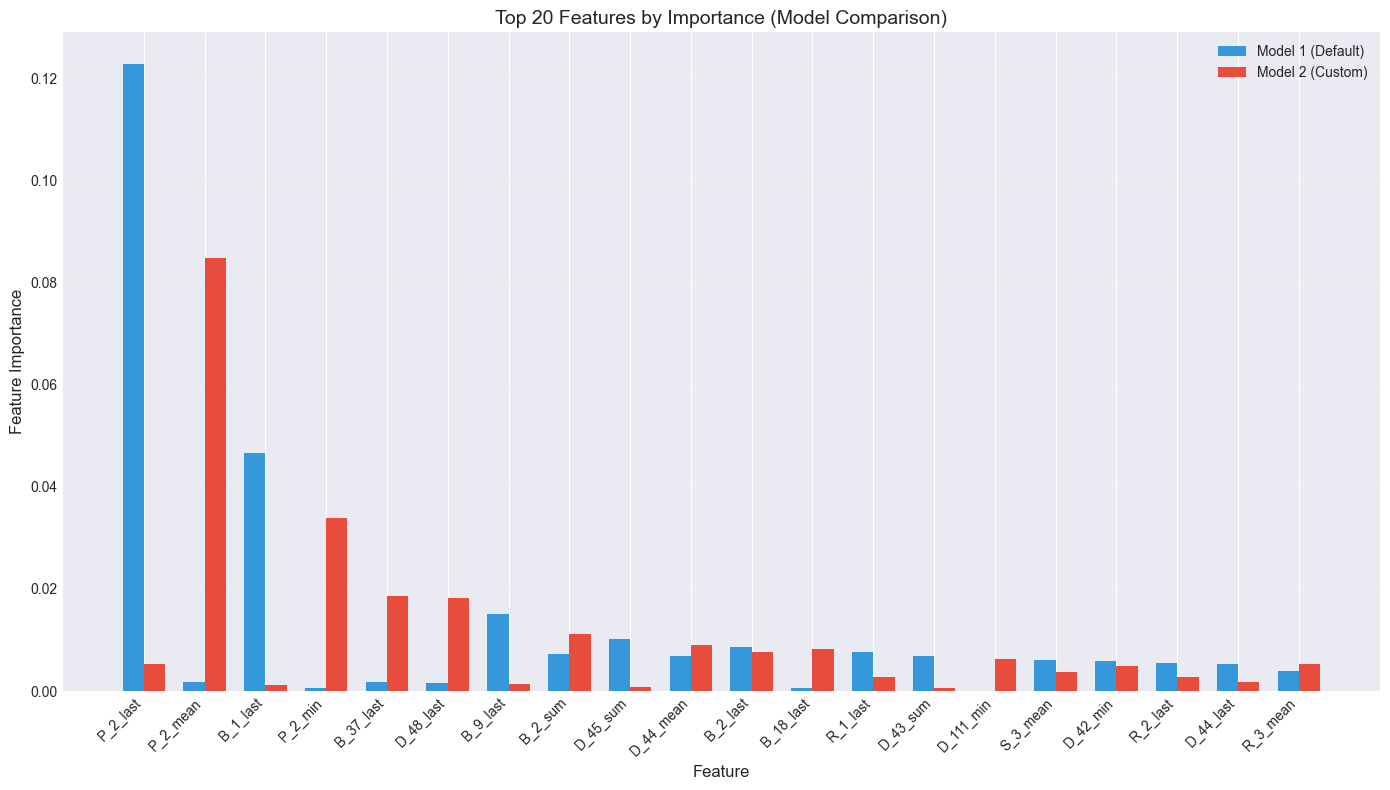

\nGenerating Category Summary Table...
\nFeature Selection Summary by Category:


,Category,# of features,# selected,Selection Rate
0,Balance,210,7,3.3%
1,Delinquency,503,7,1.4%
2,Payment,15,3,20.0%
3,Risk,140,3,2.1%
4,Spend,105,1,1.0%
5,Total,973,21,2.2%


In [60]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Load Feature Importance Files
print("Loading feature importance results...")
fi1 = pd.read_csv("feature_importance_model1.csv")
fi2 = pd.read_csv("feature_importance_model2.csv")

# Rename columns for clarity
fi1.columns = ['Feature', 'Importance_Model1']
fi2.columns = ['Feature', 'Importance_Model2']

# Merge DataFrames
merged = fi1.merge(fi2, on='Feature', how='outer').fillna(0.0)

# Calculate Max Importance for sorting
merged['Max_Importance'] = merged[['Importance_Model1', 'Importance_Model2']].max(axis=1)
merged = merged.sort_values('Max_Importance', ascending=False).reset_index(drop=True)

# 2. Save to Excel
print("Saving results to Excel...")
with pd.ExcelWriter('feature_importance_results.xlsx') as writer:
    merged.to_excel(writer, sheet_name='Comparison', index=False)
    fi1.to_excel(writer, sheet_name='Model 1 (Default)', index=False)
    fi2.to_excel(writer, sheet_name='Model 2 (Custom)', index=False)
print("✓ Saved feature_importance_results.xlsx")

# 3. Plot Top 20 Features (Grouped Bar Chart)
print("\\nGenerating Top 20 Features Graph...")
top_n = 20
plot_df = merged.head(top_n).copy()

plt.figure(figsize=(14, 8))
x = np.arange(len(plot_df))
width = 0.35

plt.bar(x - width/2, plot_df['Importance_Model1'], width, label='Model 1 (Default)', color='#3498db')
plt.bar(x + width/2, plot_df['Importance_Model2'], width, label='Model 2 (Custom)', color='#e74c3c')

plt.xlabel('Feature', fontsize=12)
plt.ylabel('Feature Importance', fontsize=12)
plt.title(f'Top {top_n} Features by Importance (Model Comparison)', fontsize=14)
plt.xticks(x, plot_df['Feature'], rotation=45, ha='right')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# 4. Summary Table by Category
print("\\nGenerating Category Summary Table...")

def get_category(feature_name):
    if str(feature_name).startswith('D_'): return 'Delinquency'
    if str(feature_name).startswith('S_'): return 'Spend'
    if str(feature_name).startswith('P_'): return 'Payment'
    if str(feature_name).startswith('B_'): return 'Balance'
    if str(feature_name).startswith('R_'): return 'Risk'
    return 'Other'

# Get total features count (from merged dataframe which contains all features)
merged['Category'] = merged['Feature'].apply(get_category)
summary_all = merged.groupby('Category').size().reset_index(name='# of features')

# Get selected features count (Importance > 0.005 in EITHER model)
# Note: We use the Max_Importance we calculated earlier
selected_df = merged[merged['Max_Importance'] > 0.005].copy()
summary_selected = selected_df.groupby('Category').size().reset_index(name='# selected')

# Merge summaries
final_table = summary_all.merge(summary_selected, on='Category', how='left')
final_table['# selected'] = final_table['# selected'].fillna(0).astype(int)

# Add Selection Rate
final_table['Selection Rate'] = (final_table['# selected'] / final_table['# of features'] * 100).map('{:.1f}%'.format)

# Add Total Row
total_row = pd.DataFrame({
    'Category': ['Total'],
    '# of features': [final_table['# of features'].sum()],
    '# selected': [final_table['# selected'].sum()],
    'Selection Rate': [f"{(final_table['# selected'].sum() / final_table['# of features'].sum() * 100):.1f}%"]
})

final_table = pd.concat([final_table, total_row], ignore_index=True)

print("\\nFeature Selection Summary by Category:")
display(final_table)

##  Grid Search Visualization

We will visualize the results of our Grid Search to select the best model.
We will calculate the **Average AUC** and **Standard Deviation of AUC** across the three samples (Train, Test1, Test2) for each model.

**Visualizations:**
1.  **Scatter Plot 1: Average AUC vs. Standard Deviation**
    - **Goal**: Identify models with **High Average AUC** (High Performance) and **Low Standard Deviation** (High Stability).
    - **Selection**: Choose models in the **bottom-right** corner.

2.  **Scatter Plot 2: Train AUC vs. Test2 AUC**
    - **Goal**: Identify models with **High Test2 AUC** and minimal gap between Train and Test2 (Low Overfitting).
    - **Selection**: Choose models close to the diagonal line (y=x) with high values.

Loading grid search results...
Selected Model 1 (Stability): Avg AUC=0.9501, Std=0.0046
Selected Model 2 (Generalization): Test2 AUC=0.9488, Gap=0.0162


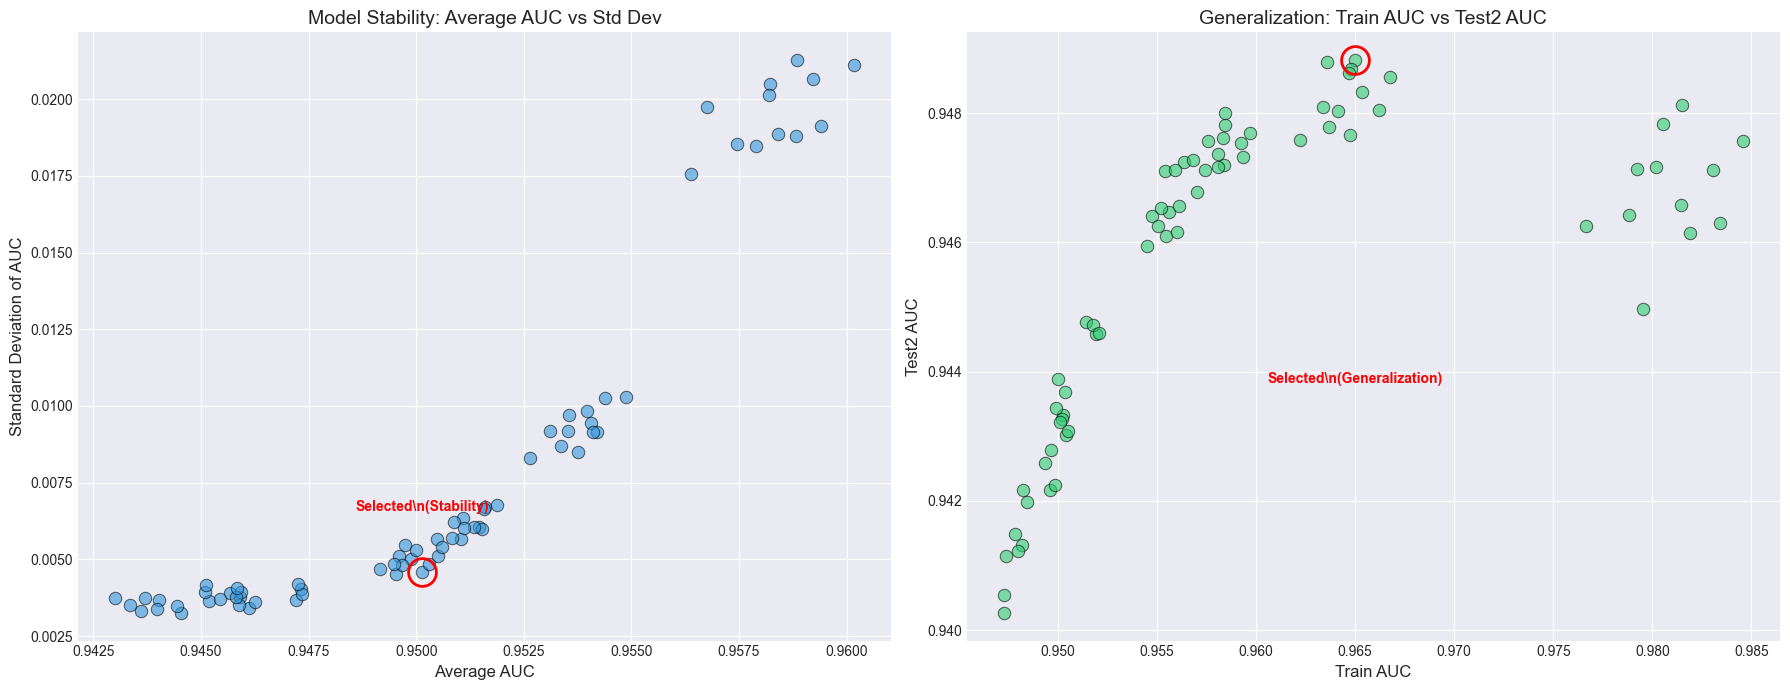

\nSelected Model based on Stability (Plot 1):


# Trees,LR,Subsample,% Features,Weight of Default,AUC Train,AUC Test 2,abs_gap (Train-Test2),Average AUC,Std AUC
300,0.010000,0.500000,0.500000,1.000000,0.955400,0.947100,0.008300,0.950100,0.004575


\nSelected Model based on Generalization (Plot 2):


# Trees,LR,Subsample,% Features,Weight of Default,AUC Train,AUC Test 2,abs_gap (Train-Test2),Average AUC,Std AUC
100,0.100000,0.500000,1.000000,1.000000,0.965000,0.948800,0.016200,0.954100,0.009451


In [62]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Load Grid Search Results
print("Loading grid search results...")
results = pd.read_csv('grid_search_results.csv')

# 2. Calculate Metrics
results['avg_auc'] = results[['auc_train', 'auc_test1', 'auc_test2']].mean(axis=1)
results['std_auc'] = results[['auc_train', 'auc_test1', 'auc_test2']].std(axis=1)
results['abs_gap'] = (results['auc_train'] - results['auc_test2']).abs()

# 3. Select Best Models
# Model 1: Best Stability (High Avg AUC, Low Std Dev)
# Heuristic: Maximize (Avg AUC - Std AUC)
results['stability_score'] = results['avg_auc'] - results['std_auc']
best_stability_model = results.loc[results['stability_score'].idxmax()]

# Model 2: Best Generalization (High Test2 AUC, Low Gap)
# Heuristic: Maximize Test2 AUC where Gap < 0.02 (or just max Test2 if all gaps large)
low_gap_models = results[results['abs_gap'] < 0.02]
if not low_gap_models.empty:
    best_generalization_model = low_gap_models.loc[low_gap_models['auc_test2'].idxmax()]
else:
    best_generalization_model = results.loc[results['auc_test2'].idxmax()]

print(f"Selected Model 1 (Stability): Avg AUC={best_stability_model['avg_auc']:.4f}, Std={best_stability_model['std_auc']:.4f}")
print(f"Selected Model 2 (Generalization): Test2 AUC={best_generalization_model['auc_test2']:.4f}, Gap={best_generalization_model['abs_gap']:.4f}")

# 4. Create Scatter Plots
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# --- Plot 1: Average AUC vs Std Dev ---
sns.scatterplot(
    data=results, 
    x='avg_auc', 
    y='std_auc', 
    ax=axes[0], 
    s=80, 
    alpha=0.6,
    color='#3498db',
    edgecolor='k'
)
axes[0].set_title('Model Stability: Average AUC vs Std Dev', fontsize=14)
axes[0].set_xlabel('Average AUC', fontsize=12)
axes[0].set_ylabel('Standard Deviation of AUC', fontsize=12)

# Circle Best Stability Model
axes[0].plot(best_stability_model['avg_auc'], best_stability_model['std_auc'], 
             'o', ms=20, mec='r', mfc='none', mew=2)
axes[0].annotate('Selected\\n(Stability)', 
                 xy=(best_stability_model['avg_auc'], best_stability_model['std_auc']),
                 xytext=(best_stability_model['avg_auc'], best_stability_model['std_auc'] + 0.002),
                 ha='center', color='r', fontweight='bold')


# --- Plot 2: Train AUC vs Test2 AUC ---
sns.scatterplot(
    data=results, 
    x='auc_train', 
    y='auc_test2', 
    ax=axes[1], 
    s=80, 
    alpha=0.6,
    color='#2ecc71',
    edgecolor='k'
)
axes[1].set_title('Generalization: Train AUC vs Test2 AUC', fontsize=14)
axes[1].set_xlabel('Train AUC', fontsize=12)
axes[1].set_ylabel('Test2 AUC', fontsize=12)

# Circle Best Generalization Model
axes[1].plot(best_generalization_model['auc_train'], best_generalization_model['auc_test2'], 
             'o', ms=20, mec='r', mfc='none', mew=2)
axes[1].annotate('Selected\\n(Generalization)', 
                 xy=(best_generalization_model['auc_train'], best_generalization_model['auc_test2']),
                 xytext=(best_generalization_model['auc_train'], best_generalization_model['auc_test2'] - 0.005),
                 ha='center', color='r', fontweight='bold')

plt.tight_layout()
plt.show()

# 5. Generate Summary Boxes (Tables)
def create_summary_box(model_row, title):
    box_data = {
        '# Trees': [int(model_row['n_estimators'])],
        'LR': [model_row['learning_rate']],
        'Subsample': [model_row['subsample']],
        '% Features': [model_row['colsample_bytree']],
        'Weight of Default': [model_row['scale_pos_weight']],
        'AUC Train': [round(model_row['auc_train'], 4)],
        'AUC Test 2': [round(model_row['auc_test2'], 4)],
        'abs_gap (Train-Test2)': [round(model_row['abs_gap'], 4)],
        'Average AUC': [round(model_row['avg_auc'], 4)],
        'Std AUC': [round(model_row['std_auc'], 6)]
    }
    df = pd.DataFrame(box_data)
    print(f"\\n{title}")
    display(df.style.hide(axis='index').set_properties(**{'text-align': 'center', 'border': '1px solid black'}))

create_summary_box(best_stability_model, "Selected Model based on Stability (Plot 1):")
create_summary_box(best_generalization_model, "Selected Model based on Generalization (Plot 2):")

## Final Model Evaluation & Rank Ordering

We will select the final model, retrain it, and perform a detailed evaluation.

**Process:**
1.  **Select Final Model**: We choose the model with the **Best Generalization** (High Test2 AUC with minimal overfitting gap) from Step 13.
2.  **Retrain**: Train this model on the full training set using the selected features.
3.  **Evaluate**: Calculate AUC for Train, Test1, and Test2.
4.  **Rank Ordering Analysis**:
    - Create 10 score bins (deciles) based on the **Train** sample predictions.
    - Apply the **same bin thresholds** to Test1 and Test2.
    - Calculate the Default Rate for each bin in each sample.
    - Visualize with a **Grouped Bar Chart** to verify that the model ranks risk consistently across all datasets.

Loading data and results...
\nSelected Final Model Parameters:


,n_estimators,learning_rate,subsample,colsample_bytree,scale_pos_weight,objective,n_jobs,random_state,enable_categorical
0,100,0.1,0.5,1.0,1.0,binary:logistic,-1,42,True


\nRetraining final model...
Predicting probabilities...
\nFinal Model Performance:


Sample,AUC
Train,0.9650
Test 1,0.9484
Test 2,0.9488


\nPerforming Rank Ordering Analysis...


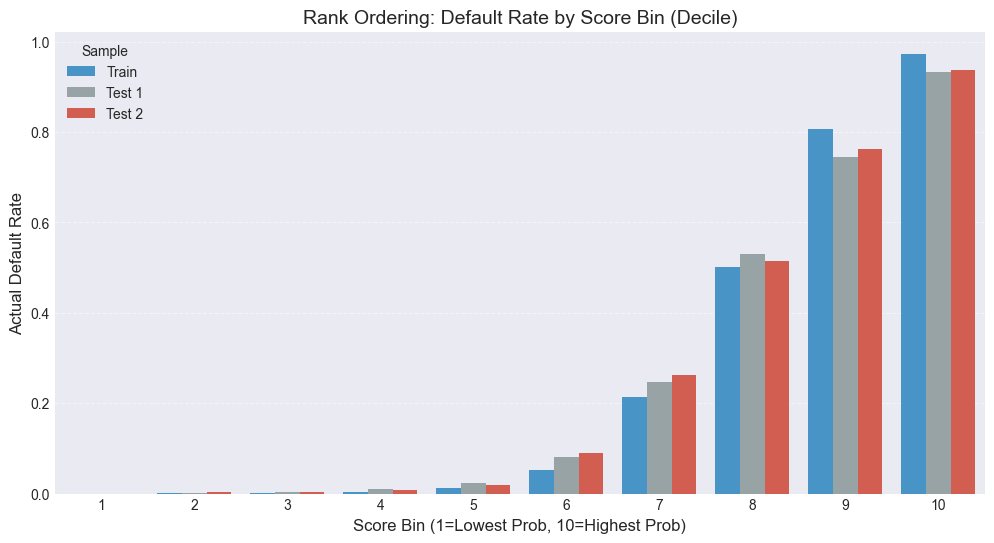

Interpretation: A good model should show a monotonically increasing Default Rate from Bin 1 to 10 across all samples.


In [63]:
import pandas as pd
import xgboost as xgb
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Load Data & Results
print("Loading data and results...")
grid_results = pd.read_csv('grid_search_results.csv')
train_data = pd.read_csv('train_data_split.csv')
test1_data = pd.read_csv('test1_data_split.csv')
test2_data = pd.read_csv('test2_data_split.csv')
selected_features = pd.read_csv('selected_features.csv')['feature'].tolist()

# 2. Select Final Model (Best Generalization)
# Logic: Maximize Test2 AUC where Gap < 0.02, else max Test2 AUC
grid_results['abs_gap'] = (grid_results['auc_train'] - grid_results['auc_test2']).abs()
low_gap_models = grid_results[grid_results['abs_gap'] < 0.02]

if not low_gap_models.empty:
    best_model_row = low_gap_models.loc[low_gap_models['auc_test2'].idxmax()]
else:
    best_model_row = grid_results.loc[grid_results['auc_test2'].idxmax()]

print("\\nSelected Final Model Parameters:")
params = {
    'n_estimators': int(best_model_row['n_estimators']),
    'learning_rate': best_model_row['learning_rate'],
    'subsample': best_model_row['subsample'],
    'colsample_bytree': best_model_row['colsample_bytree'],
    'scale_pos_weight': best_model_row['scale_pos_weight'],
    'objective': 'binary:logistic',
    'n_jobs': -1,
    'random_state': 42,
    'enable_categorical': True
}
display(pd.DataFrame([params]))

# 3. Retrain Final Model
print("\\nRetraining final model...")
X_train = train_data[selected_features]
y_train = train_data['target']
X_test1 = test1_data[selected_features]
y_test1 = test1_data['target']
X_test2 = test2_data[selected_features]
y_test2 = test2_data['target']

final_model = xgb.XGBClassifier(**params)
final_model.fit(X_train, y_train)

# 4. Predict Probabilities
print("Predicting probabilities...")
prob_train = final_model.predict_proba(X_train)[:, 1]
prob_test1 = final_model.predict_proba(X_test1)[:, 1]
prob_test2 = final_model.predict_proba(X_test2)[:, 1]

# 5. Calculate & Display AUCs
auc_train = roc_auc_score(y_train, prob_train)
auc_test1 = roc_auc_score(y_test1, prob_test1)
auc_test2 = roc_auc_score(y_test2, prob_test2)

auc_df = pd.DataFrame({
    'Sample': ['Train', 'Test 1', 'Test 2'],
    'AUC': [auc_train, auc_test1, auc_test2]
})
print("\\nFinal Model Performance:")
display(auc_df.style.hide(axis='index').format({'AUC': '{:.4f}'}))

# 6. Rank Ordering Analysis
print("\\nPerforming Rank Ordering Analysis...")

# Create DataFrame for analysis
df_train_res = pd.DataFrame({'target': y_train, 'prob': prob_train})
df_test1_res = pd.DataFrame({'target': y_test1, 'prob': prob_test1})
df_test2_res = pd.DataFrame({'target': y_test2, 'prob': prob_test2})

# Create Bins based on TRAIN data (Deciles)
# qcut returns the bins (intervals)
_, bins = pd.qcut(df_train_res['prob'], q=10, retbins=True, duplicates='drop')

# Apply bins to all datasets
# Use cut with the bins from train
df_train_res['bin'] = pd.cut(df_train_res['prob'], bins=bins, include_lowest=True)
df_test1_res['bin'] = pd.cut(df_test1_res['prob'], bins=bins, include_lowest=True)
df_test2_res['bin'] = pd.cut(df_test2_res['prob'], bins=bins, include_lowest=True)

# Calculate Default Rate per Bin
def get_bin_stats(df, name):
    stats = df.groupby('bin')['target'].mean().reset_index()
    stats.columns = ['Bin', 'Default Rate']
    stats['Sample'] = name
    # Add bin labels (1-10) for cleaner plotting
    stats['Bin Label'] = range(1, len(stats) + 1)
    return stats

rank_train = get_bin_stats(df_train_res, 'Train')
rank_test1 = get_bin_stats(df_test1_res, 'Test 1')
rank_test2 = get_bin_stats(df_test2_res, 'Test 2')

# Combine for plotting
rank_all = pd.concat([rank_train, rank_test1, rank_test2])

# 7. Plot Rank Ordering
plt.figure(figsize=(12, 6))
sns.barplot(data=rank_all, x='Bin Label', y='Default Rate', hue='Sample', palette=['#3498db', '#95a5a6', '#e74c3c'])

plt.title('Rank Ordering: Default Rate by Score Bin (Decile)', fontsize=14)
plt.xlabel('Score Bin (1=Lowest Prob, 10=Highest Prob)', fontsize=12)
plt.ylabel('Actual Default Rate', fontsize=12)
plt.legend(title='Sample')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

print("Interpretation: A good model should show a monotonically increasing Default Rate from Bin 1 to 10 across all samples.")

## SHAP Analysis

We will use **SHAP (SHapley Additive exPlanations)** to explain the output of our final model on the **Test 2** sample.

**Visualizations:**
1.  **Beeswarm Plot**: This plot shows how each feature impacts the model's output.
    - **Y-axis**: Features ranked by importance.
    - **X-axis**: SHAP value (impact on model output). Positive values increase default risk, negative values decrease it.
    - **Color**: Feature value (Red = High, Blue = Low).

**Interpretation:**
We will analyze the top features to understand the direction of their relationship with default risk (e.g., "Does a high balance increase or decrease the risk?").

Initializing SHAP Explainer...
SHAP values calculated for Test 2 sample.
\nGenerating Beeswarm Plot...


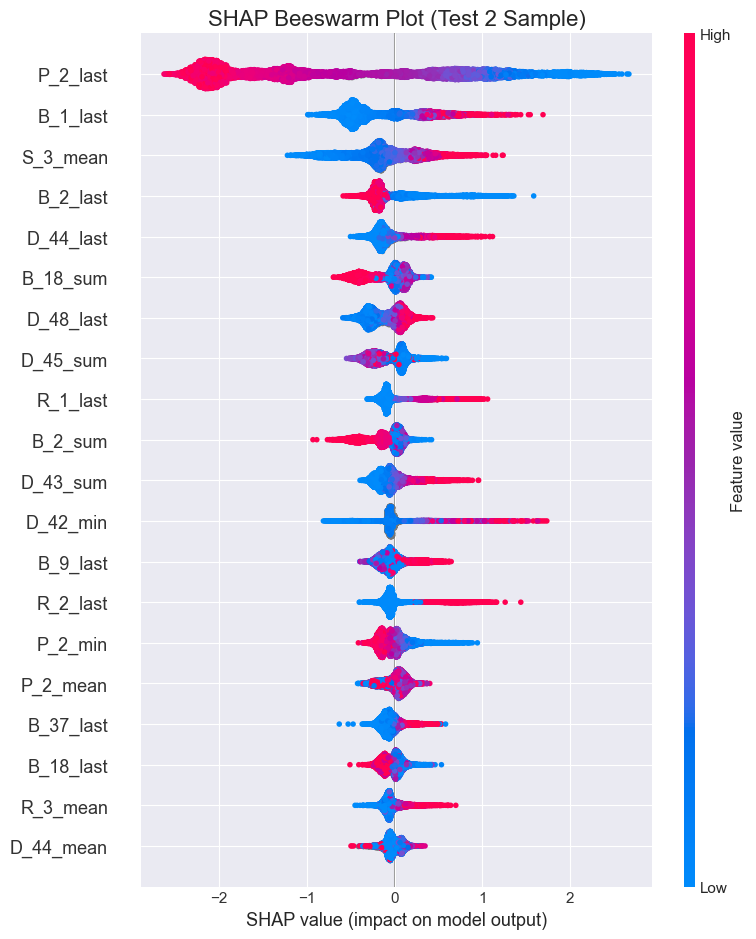

\nInterpretation Guide:
- **Feature Ranking**: Features at the top have the biggest impact on the model.
- **Color**: Red dots represent HIGH feature values, Blue dots represent LOW feature values.
- **X-Axis (Impact)**: Points to the RIGHT increase default risk (positive SHAP). Points to the LEFT decrease risk.
\nExample Analysis:
If 'P_2' (Payment variable) has red dots on the left, it means HIGH payments reduce default risk.


In [64]:
import shap
import matplotlib.pyplot as plt
import pandas as pd

# 1. Initialize SHAP Explainer
print("Initializing SHAP Explainer...")
# We use the final_model and X_test2 from the previous step
# Ensure final_model is available. If not, please run Step 14.
try:
    explainer = shap.TreeExplainer(final_model)
    shap_values = explainer.shap_values(X_test2)
    print("SHAP values calculated for Test 2 sample.")
except NameError:
    print("Error: 'final_model' or 'X_test2' not found. Please ensure Step 14 has been run.")

# 2. Generate Beeswarm Plot
print("\\nGenerating Beeswarm Plot...")
plt.figure(figsize=(12, 10))
shap.summary_plot(shap_values, X_test2, show=False)
plt.title('SHAP Beeswarm Plot (Test 2 Sample)', fontsize=16)
plt.tight_layout()
plt.show()

# 3. Interpretation Helper
print("\\nInterpretation Guide:")
print("- **Feature Ranking**: Features at the top have the biggest impact on the model.")
print("- **Color**: Red dots represent HIGH feature values, Blue dots represent LOW feature values.")
print("- **X-Axis (Impact)**: Points to the RIGHT increase default risk (positive SHAP). Points to the LEFT decrease risk.")
print("\\nExample Analysis:")
print("If 'P_2' (Payment variable) has red dots on the left, it means HIGH payments reduce default risk.")

In [66]:

# 4. Top 5 Features Summary Statistics
print("\\nGenerating Summary Statistics for Top 5 SHAP Features...")

# Identify Top 5 Features by Mean Absolute SHAP Value
# shap_values is a numpy array, X_test2 is a DataFrame
mean_abs_shap = np.abs(shap_values).mean(axis=0)
feature_names = X_test2.columns
shap_importance = pd.DataFrame({'feature': feature_names, 'importance': mean_abs_shap})
top_5_features = shap_importance.sort_values('importance', ascending=False).head(5)['feature'].tolist()

print(f"Top 5 Features: {top_5_features}")

# Calculate Statistics on Training Data (to represent the model's 'knowledge')
# We use train_data (loaded in Step 14)
stats_data = []

for feat in top_5_features:
    series = train_data[feat]
    
    stats_row = {
        'Feature': feat,
        'Min': series.min(),
        '1 Percentile': series.quantile(0.01),
        '5 Percentile': series.quantile(0.05),
        'Median': series.median(),
        '95 Percentile': series.quantile(0.95),
        '99 Percentile': series.quantile(0.99),
        'Max': series.max(),
        'Mean': series.mean(),
        '% Missing': (series.isnull().mean() * 100)
    }
    stats_data.append(stats_row)

stats_df = pd.DataFrame(stats_data)

# Format for display
print("\\nSummary Statistics for Top 5 Features (Training Data):")
display(stats_df.style.hide(axis='index').format({
    'Min': '{:.4f}',
    '1 Percentile': '{:.4f}',
    '5 Percentile': '{:.4f}',
    'Median': '{:.4f}',
    '95 Percentile': '{:.4f}',
    '99 Percentile': '{:.4f}',
    'Max': '{:.4f}',
    'Mean': '{:.4f}',
    '% Missing': '{:.2f}%'
}).set_properties(**{'text-align': 'center', 'border': '1px solid black'}))

\nGenerating Summary Statistics for Top 5 SHAP Features...
Top 5 Features: ['P_2_last', 'B_1_last', 'S_3_mean', 'B_2_last', 'D_44_last']
\nSummary Statistics for Top 5 Features (Training Data):


Feature,Min,1 Percentile,5 Percentile,Median,95 Percentile,99 Percentile,Max,Mean,% Missing
P_2_last,-0.3915,-0.0808,0.1354,0.6815,0.9776,1.0062,1.0100,0.6350,0.51%
B_1_last,-0.1271,0.0005,0.0021,0.0332,0.6633,1.0760,1.3240,0.1383,0.00%
S_3_mean,-0.2947,0.0231,0.0720,0.1736,0.5607,0.8927,3.8609,0.2289,12.43%
B_2_last,0.0000,0.0017,0.0086,0.8134,1.0084,1.0097,1.0100,0.5925,0.00%
D_44_last,0.0000,0.0002,0.0008,0.0080,0.6323,1.1288,4.0055,0.1384,3.83%


## SHAP Waterfall Analysis

We will use a **Waterfall Plot** to explain the prediction for a **single observation** from the Test 2 sample.

**Visualizations:**
1.  **Waterfall Plot**: This plot shows how each feature contributed to moving the model's prediction from the **baseline value** (average model output) to the **final score** for this specific customer.
    - **Red bars**: Features that pushed the score **HIGHER** (increased default risk).
    - **Blue bars**: Features that pushed the score **LOWER** (decreased default risk).

**Interpretation:**
This helps us understand the specific reasons why the model assigned a high or low score to this particular customer.

Selecting an observation for analysis...
Selected Observation Index: 0
\nGenerating Waterfall Plot...


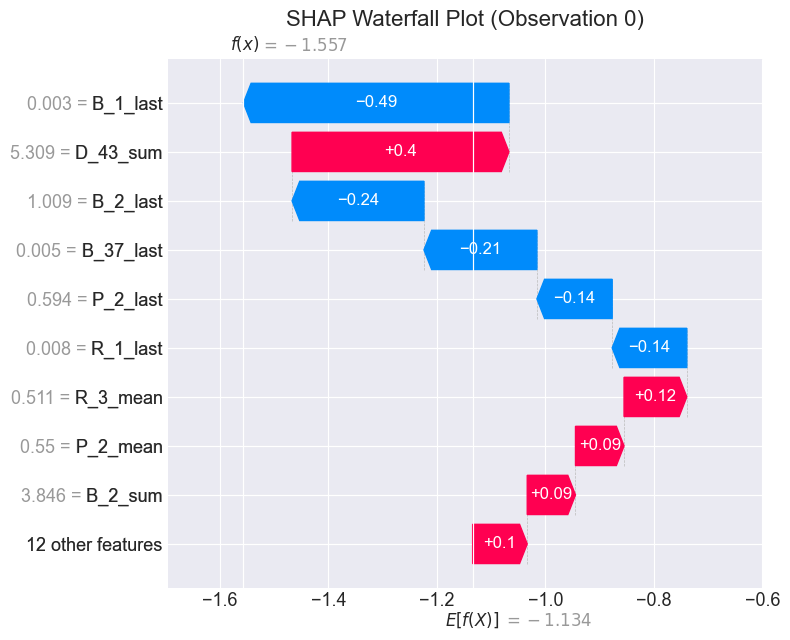

\nInterpretation Guide:
- **E[f(x)] (Baseline)**: The average model output (log-odds) across the dataset.
- **f(x) (Final Score)**: The model's output for this specific observation.
- **Red Bars**: Features that increased the risk for this customer.
- **Blue Bars**: Features that decreased the risk for this customer.
\nActionable Insight:
To improve the score (reduce risk), focus on the features with large RED bars. Changing these values (e.g., reducing balance, increasing payments) would have the biggest impact.


In [67]:
import shap
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 1. Select an Observation
print("Selecting an observation for analysis...")
# Let's pick an observation with a relatively high predicted probability to see what drives risk
# We need to get predictions first if we want to pick a high risk one, or just pick random
# Here we pick the first one for simplicity, or you can change the index
obs_index = 0 

# Ensure we have the explainer from Step 15
try:
    # We need the 'Explanation' object for the waterfall plot, not just shap_values array
    # TreeExplainer(model)(X) returns an Explanation object
    explanation = explainer(X_test2)
    print(f"Selected Observation Index: {obs_index}")
except NameError:
    print("Error: 'explainer' or 'X_test2' not found. Please ensure Step 15 has been run.")

# 2. Generate Waterfall Plot
print("\\nGenerating Waterfall Plot...")
plt.figure(figsize=(10, 6))
# shap.plots.waterfall takes a single Explanation object
shap.plots.waterfall(explanation[obs_index], show=False)
plt.title(f'SHAP Waterfall Plot (Observation {obs_index})', fontsize=16)
plt.tight_layout()
plt.show()

# 3. Interpretation Helper
print("\\nInterpretation Guide:")
print("- **E[f(x)] (Baseline)**: The average model output (log-odds) across the dataset.")
print("- **f(x) (Final Score)**: The model's output for this specific observation.")
print("- **Red Bars**: Features that increased the risk for this customer.")
print("- **Blue Bars**: Features that decreased the risk for this customer.")
print("\\nActionable Insight:")
print("To improve the score (reduce risk), focus on the features with large RED bars. Changing these values (e.g., reducing balance, increasing payments) would have the biggest impact.")

## Step 11: Neural Network Data Preparation

Before training a Neural Network, we need to process the data specifically for it. Neural Networks are sensitive to the scale of input data and outliers.

**Process:**
1.  **Feature Selection**: We use the same features selected in Step 8/12.
2.  **Missing Value Imputation**: Replace missing values with 0.
3.  **Outlier Treatment**: Cap and floor values at the 1st and 99th percentiles (calculated on Train data).
4.  **Normalization**: Standardize features (mean=0, std=1) using `StandardScaler`.
5.  **Save Data**: Save the processed datasets for the next step.

In [68]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# 1. Load Data & Selected Features
print("Loading data...")
train_data = pd.read_csv('train_data_split.csv')
test1_data = pd.read_csv('test1_data_split.csv')
test2_data = pd.read_csv('test2_data_split.csv')
selected_features = pd.read_csv('selected_features.csv')['feature'].tolist()

# Filter to keep only selected features + target
# We need target for training/eval, but we only process features
target_col = 'target'
X_train = train_data[selected_features].copy()
y_train = train_data[target_col]

X_test1 = test1_data[selected_features].copy()
y_test1 = test1_data[target_col]

X_test2 = test2_data[selected_features].copy()
y_test2 = test2_data[target_col]

print(f"Selected {len(selected_features)} features for Neural Network.")

# 2. Missing Value Imputation (Fill with 0)
print("Imputing missing values with 0...")
X_train.fillna(0, inplace=True)
X_test1.fillna(0, inplace=True)
X_test2.fillna(0, inplace=True)

# 3. Outlier Treatment (Cap/Floor at 1% and 99%)
print("Handling outliers (1% - 99% capping)...")
# Calculate bounds on TRAIN data only
lower_bounds = X_train.quantile(0.01)
upper_bounds = X_train.quantile(0.99)

# Apply to all datasets
def clip_outliers(df, lower, upper):
    return df.clip(lower=lower, upper=upper, axis=1)

X_train = clip_outliers(X_train, lower_bounds, upper_bounds)
X_test1 = clip_outliers(X_test1, lower_bounds, upper_bounds)
X_test2 = clip_outliers(X_test2, lower_bounds, upper_bounds)

# 4. Normalization (StandardScaler)
print("Normalizing data (StandardScaler)...")
scaler = StandardScaler()
# Fit on TRAIN data only
scaler.fit(X_train)

# Transform all
X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns=selected_features)
X_test1_scaled = pd.DataFrame(scaler.transform(X_test1), columns=selected_features)
X_test2_scaled = pd.DataFrame(scaler.transform(X_test2), columns=selected_features)

# 5. Save Processed Data
print("Saving processed data for Neural Network...")
# Reattach target for saving
train_nn = pd.concat([X_train_scaled, y_train.reset_index(drop=True)], axis=1)
test1_nn = pd.concat([X_test1_scaled, y_test1.reset_index(drop=True)], axis=1)
test2_nn = pd.concat([X_test2_scaled, y_test2.reset_index(drop=True)], axis=1)

train_nn.to_csv('train_data_nn.csv', index=False)
test1_nn.to_csv('test1_data_nn.csv', index=False)
test2_nn.to_csv('test2_data_nn.csv', index=False)

print("Data saved: 'train_data_nn.csv', 'test1_data_nn.csv', 'test2_data_nn.csv'")

Loading data...
Selected 21 features for Neural Network.
Imputing missing values with 0...
Handling outliers (1% - 99% capping)...
Normalizing data (StandardScaler)...
Saving processed data for Neural Network...
Data saved: 'train_data_nn.csv', 'test1_data_nn.csv', 'test2_data_nn.csv'


## Step 12: Neural Network Grid Search

We will perform a Grid Search to find the best hyperparameters for our Neural Network.

**Grid Parameters:**
-   **Hidden Layers**: 2, 4
-   **Nodes per Layer**: 4, 6
-   **Activation**: ReLU, Tanh
-   **Dropout Rate**: 50% (0.5), 0% (No Dropout)
-   **Batch Size**: 100, 10000

**Fixed Parameters:**
-   **Optimizer**: Adam
-   **Loss Function**: Binary Cross Entropy
-   **Epochs**: 20

**Process:**
We will iterate through all combinations, train a model for each, calculate AUC scores, and save the results to `nn_grid_search_results.csv` in real-time.

In [69]:
import pandas as pd
import numpy as np
import tensorflow as pd_tf # Alias to avoid conflict if user has 'tf' variable
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import roc_auc_score
import os
import itertools

# 1. Load Processed Data
print("Loading processed data...")
train_nn = pd.read_csv('train_data_nn.csv')
test1_nn = pd.read_csv('test1_data_nn.csv')
test2_nn = pd.read_csv('test2_data_nn.csv')

# Separate features and target
target_col = 'target'
X_train = train_nn.drop(columns=[target_col])
y_train = train_nn[target_col]
X_test1 = test1_nn.drop(columns=[target_col])
y_test1 = test1_nn[target_col]
X_test2 = test2_nn.drop(columns=[target_col])
y_test2 = test2_nn[target_col]

input_dim = X_train.shape[1]
print(f"Input dimension: {input_dim}")

# 2. Define Grid
hidden_layers_list = [2, 4]
nodes_list = [4, 6]
activations_list = ['relu', 'tanh']
dropout_list = [0.5, 0.0] # 0.0 means no dropout (keep 100%)
batch_sizes_list = [100, 10000]

# Prepare results file
results_file = 'nn_grid_search_results.csv'
if os.path.exists(results_file):
    print(f"Warning: {results_file} already exists. Appending to it.")
else:
    # Create header
    pd.DataFrame(columns=['# HL', '# Node', 'Activation Function', 'Dropout', 'Batch Size', 'AUC Train', 'AUC Test 1', 'AUC Test 2']).to_csv(results_file, index=False)

# 3. Grid Search Loop
print("Starting Grid Search...")
total_combinations = len(hidden_layers_list) * len(nodes_list) * len(activations_list) * len(dropout_list) * len(batch_sizes_list)
print(f"Total combinations to test: {total_combinations}")

counter = 0

# Separate loops for Hidden Layers as requested
for n_layers in hidden_layers_list:
    # Loop for other parameters
    for n_nodes, activation, dropout, batch_size in itertools.product(nodes_list, activations_list, dropout_list, batch_sizes_list):
        counter += 1
        print(f"\\nIteration {counter}/{total_combinations}: Layers={n_layers}, Nodes={n_nodes}, Act={activation}, Drop={dropout}, Batch={batch_size}")
        
        # Build Model
        model = keras.Sequential()
        model.add(layers.Input(shape=(input_dim,)))
        
        for _ in range(n_layers):
            model.add(layers.Dense(n_nodes, activation=activation))
            if dropout > 0:
                model.add(layers.Dropout(dropout))
        
        # Output Layer
        model.add(layers.Dense(1, activation='sigmoid'))
        
        # Compile
        model.compile(optimizer='adam', loss='binary_crossentropy')
        
        # Train
        # Verbose=0 to reduce clutter, we print progress manually
        model.fit(X_train, y_train, epochs=20, batch_size=batch_size, verbose=0)
        
        # Predict
        prob_train = model.predict(X_train, verbose=0).flatten()
        prob_test1 = model.predict(X_test1, verbose=0).flatten()
        prob_test2 = model.predict(X_test2, verbose=0).flatten()
        
        # Calculate AUC
        auc_train = roc_auc_score(y_train, prob_train)
        auc_test1 = roc_auc_score(y_test1, prob_test1)
        auc_test2 = roc_auc_score(y_test2, prob_test2)
        
        # Save Results
        result_row = {
            '# HL': n_layers,
            '# Node': n_nodes,
            'Activation Function': activation,
            'Dropout': f"{int(dropout*100)}%" if dropout > 0 else "0%", # Format as requested
            'Batch Size': batch_size,
            'AUC Train': round(auc_train, 4),
            'AUC Test 1': round(auc_test1, 4),
            'AUC Test 2': round(auc_test2, 4)
        }
        
        pd.DataFrame([result_row]).to_csv(results_file, mode='a', header=False, index=False)
        print(f"   Result: Train={auc_train:.4f}, Test1={auc_test1:.4f}, Test2={auc_test2:.4f}")

print("\\nGrid Search Complete!")
final_results = pd.read_csv(results_file)
display(final_results)

Loading processed data...
Input dimension: 21
Starting Grid Search...
Total combinations to test: 32
\nIteration 1/32: Layers=2, Nodes=4, Act=relu, Drop=0.5, Batch=100


2025-11-26 19:00:21.290632: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2025-11-26 19:00:21.290672: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-11-26 19:00:21.290678: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-11-26 19:00:21.291003: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-11-26 19:00:21.291018: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2025-11-26 19:00:22.537282: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2025-11-26 19:00:22.541294: E te

   Result: Train=0.9304, Test1=0.9298, Test2=0.9282
\nIteration 2/32: Layers=2, Nodes=4, Act=relu, Drop=0.5, Batch=10000
   Result: Train=0.8960, Test1=0.8973, Test2=0.8986
\nIteration 3/32: Layers=2, Nodes=4, Act=relu, Drop=0.0, Batch=100


2025-11-26 19:04:14.067729: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


   Result: Train=0.9476, Test1=0.9459, Test2=0.9450
\nIteration 4/32: Layers=2, Nodes=4, Act=relu, Drop=0.0, Batch=10000
   Result: Train=0.9220, Test1=0.9203, Test2=0.9210
\nIteration 5/32: Layers=2, Nodes=4, Act=tanh, Drop=0.5, Batch=100


2025-11-26 19:06:11.286536: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


   Result: Train=0.9467, Test1=0.9456, Test2=0.9442
\nIteration 6/32: Layers=2, Nodes=4, Act=tanh, Drop=0.5, Batch=10000
   Result: Train=0.9145, Test1=0.9133, Test2=0.9145
\nIteration 7/32: Layers=2, Nodes=4, Act=tanh, Drop=0.0, Batch=100


2025-11-26 19:07:58.082797: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


   Result: Train=0.9486, Test1=0.9472, Test2=0.9459
\nIteration 8/32: Layers=2, Nodes=4, Act=tanh, Drop=0.0, Batch=10000
   Result: Train=0.9296, Test1=0.9294, Test2=0.9269
\nIteration 9/32: Layers=2, Nodes=6, Act=relu, Drop=0.5, Batch=100


2025-11-26 19:09:56.839105: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


   Result: Train=0.9473, Test1=0.9459, Test2=0.9447
\nIteration 10/32: Layers=2, Nodes=6, Act=relu, Drop=0.5, Batch=10000
   Result: Train=0.9161, Test1=0.9162, Test2=0.9145
\nIteration 11/32: Layers=2, Nodes=6, Act=relu, Drop=0.0, Batch=100


2025-11-26 19:11:46.037175: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


   Result: Train=0.9489, Test1=0.9473, Test2=0.9459
\nIteration 12/32: Layers=2, Nodes=6, Act=relu, Drop=0.0, Batch=10000
   Result: Train=0.9360, Test1=0.9350, Test2=0.9337
\nIteration 13/32: Layers=2, Nodes=6, Act=tanh, Drop=0.5, Batch=100


2025-11-26 19:13:47.092766: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


   Result: Train=0.9466, Test1=0.9455, Test2=0.9444
\nIteration 14/32: Layers=2, Nodes=6, Act=tanh, Drop=0.5, Batch=10000
   Result: Train=0.9370, Test1=0.9362, Test2=0.9343
\nIteration 15/32: Layers=2, Nodes=6, Act=tanh, Drop=0.0, Batch=100


2025-11-26 19:15:35.418568: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


   Result: Train=0.9489, Test1=0.9469, Test2=0.9464
\nIteration 16/32: Layers=2, Nodes=6, Act=tanh, Drop=0.0, Batch=10000
   Result: Train=0.9283, Test1=0.9266, Test2=0.9249
\nIteration 17/32: Layers=4, Nodes=4, Act=relu, Drop=0.5, Batch=100


2025-11-26 19:18:28.602875: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


   Result: Train=0.9090, Test1=0.9095, Test2=0.9083
\nIteration 18/32: Layers=4, Nodes=4, Act=relu, Drop=0.5, Batch=10000
   Result: Train=0.8180, Test1=0.8183, Test2=0.8170
\nIteration 19/32: Layers=4, Nodes=4, Act=relu, Drop=0.0, Batch=100


2025-11-26 19:20:59.491724: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


   Result: Train=0.9487, Test1=0.9477, Test2=0.9461
\nIteration 20/32: Layers=4, Nodes=4, Act=relu, Drop=0.0, Batch=10000
   Result: Train=0.9364, Test1=0.9353, Test2=0.9335
\nIteration 21/32: Layers=4, Nodes=4, Act=tanh, Drop=0.5, Batch=100


2025-11-26 19:23:40.242826: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


   Result: Train=0.9469, Test1=0.9456, Test2=0.9446
\nIteration 22/32: Layers=4, Nodes=4, Act=tanh, Drop=0.5, Batch=10000
   Result: Train=0.8568, Test1=0.8548, Test2=0.8550
\nIteration 23/32: Layers=4, Nodes=4, Act=tanh, Drop=0.0, Batch=100


2025-11-26 19:26:01.174474: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


   Result: Train=0.9487, Test1=0.9468, Test2=0.9457
\nIteration 24/32: Layers=4, Nodes=4, Act=tanh, Drop=0.0, Batch=10000
   Result: Train=0.9139, Test1=0.9145, Test2=0.9105
\nIteration 25/32: Layers=4, Nodes=6, Act=relu, Drop=0.5, Batch=100


2025-11-26 19:28:48.790515: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


   Result: Train=0.9304, Test1=0.9300, Test2=0.9286
\nIteration 26/32: Layers=4, Nodes=6, Act=relu, Drop=0.5, Batch=10000
   Result: Train=0.8770, Test1=0.8768, Test2=0.8764
\nIteration 27/32: Layers=4, Nodes=6, Act=relu, Drop=0.0, Batch=100


2025-11-26 19:31:11.576767: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


   Result: Train=0.9490, Test1=0.9468, Test2=0.9460
\nIteration 28/32: Layers=4, Nodes=6, Act=relu, Drop=0.0, Batch=10000
   Result: Train=0.9240, Test1=0.9245, Test2=0.9227
\nIteration 29/32: Layers=4, Nodes=6, Act=tanh, Drop=0.5, Batch=100


2025-11-26 19:33:58.077034: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


   Result: Train=0.9468, Test1=0.9457, Test2=0.9445
\nIteration 30/32: Layers=4, Nodes=6, Act=tanh, Drop=0.5, Batch=10000
   Result: Train=0.9366, Test1=0.9337, Test2=0.9334
\nIteration 31/32: Layers=4, Nodes=6, Act=tanh, Drop=0.0, Batch=100


2025-11-26 19:36:19.024964: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


   Result: Train=0.9492, Test1=0.9467, Test2=0.9464
\nIteration 32/32: Layers=4, Nodes=6, Act=tanh, Drop=0.0, Batch=10000
   Result: Train=0.9375, Test1=0.9347, Test2=0.9348
\nGrid Search Complete!


,# HL,# Node,Activation Function,Dropout,Batch Size,AUC Train,AUC Test 1,AUC Test 2
0,2,4,relu,50%,100,0.9304,0.9298,0.9282
1,2,4,relu,50%,10000,0.8960,0.8973,0.8986
2,2,4,relu,0%,100,0.9476,0.9459,0.9450
3,2,4,relu,0%,10000,0.9220,0.9203,0.9210
4,2,4,tanh,50%,100,0.9467,0.9456,0.9442
5,2,4,tanh,50%,10000,0.9145,0.9133,0.9145
6,2,4,tanh,0%,100,0.9486,0.9472,0.9459
7,2,4,tanh,0%,10000,0.9296,0.9294,0.9269
8,2,6,relu,50%,100,0.9473,0.9459,0.9447
9,2,6,relu,50%,10000,0.9161,0.9162,0.9145


## Step 13: Final Neural Network Selection

We will select the best Neural Network model based on the **Bias-Variance Trade-off**.

**Selection Logic:**
1.  **Calculate Gap**: `Gap = AUC Train - AUC Test 1`. A large gap indicates overfitting (High Variance).
2.  **Filter**: We select models with a small gap (e.g., < 0.05) to ensure stability.
3.  **Select Best**: From the stable models, we pick the one with the highest `AUC Test 1` (Low Bias).

**Retraining:**
We will retrain this optimal model on the full training set (`train_data_nn.csv`) for 20 epochs and save it as `final_nn_model.keras`.

In [70]:
import pandas as pd
import tensorflow as pd_tf
from tensorflow import keras
from tensorflow.keras import layers
import os

# 1. Load Grid Search Results
print("Loading grid search results...")
results = pd.read_csv('nn_grid_search_results.csv')

# 2. Analyze Bias & Variance
# Calculate Overfitting Gap
results['Gap'] = results['AUC Train'] - results['AUC Test 1']

# Filter for Low Variance (Gap < 0.05)
# If no model meets this, we'll relax it or just take the best Test 1
low_variance_models = results[results['Gap'] < 0.05]

if not low_variance_models.empty:
    print(f"Found {len(low_variance_models)} models with Gap < 0.05.")
    # Select Best Bias (Max Test 1 AUC)
    best_model_row = low_variance_models.loc[low_variance_models['AUC Test 1'].idxmax()]
else:
    print("No models with Gap < 0.05 found. Selecting model with best Test 1 AUC regardless of gap.")
    best_model_row = results.loc[results['AUC Test 1'].idxmax()]

print("\\nBest Model Selected:")
display(pd.DataFrame([best_model_row]))

# Extract Parameters
n_layers = int(best_model_row['# HL'])
n_nodes = int(best_model_row['# Node'])
activation = best_model_row['Activation Function']
dropout_str = best_model_row['Dropout']
# Convert "50%" -> 0.5, "0%" -> 0.0
dropout = float(dropout_str.replace('%', '')) / 100
batch_size = int(best_model_row['Batch Size'])

print(f"\\nParameters: Layers={n_layers}, Nodes={n_nodes}, Act={activation}, Drop={dropout}, Batch={batch_size}")

# 3. Retrain Final Model
print("\\nRetraining Final Model...")

# Load Training Data
train_nn = pd.read_csv('train_data_nn.csv')
target_col = 'target'
X_train = train_nn.drop(columns=[target_col])
y_train = train_nn[target_col]
input_dim = X_train.shape[1]

# Build Model
model = keras.Sequential()
model.add(layers.Input(shape=(input_dim,)))

for _ in range(n_layers):
    model.add(layers.Dense(n_nodes, activation=activation))
    if dropout > 0:
        model.add(layers.Dropout(dropout))

# Output Layer
model.add(layers.Dense(1, activation='sigmoid'))

# Compile
model.compile(optimizer='adam', loss='binary_crossentropy')

# Train
model.fit(X_train, y_train, epochs=20, batch_size=batch_size, verbose=1)

# 4. Save Model
model_filename = 'final_nn_model.keras'
model.save(model_filename)
print(f"\\nFinal model saved as '{model_filename}'")

Loading grid search results...
Found 32 models with Gap < 0.05.
\nBest Model Selected:


,# HL,# Node,Activation Function,Dropout,Batch Size,AUC Train,AUC Test 1,AUC Test 2,Gap
18,4,4,relu,0%,100,0.9487,0.9477,0.9461,0.001


\nParameters: Layers=4, Nodes=4, Act=relu, Drop=0.0, Batch=100
\nRetraining Final Model...
Epoch 1/20


2025-11-26 19:40:59.905156: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


643/643 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 0.4602
Epoch 2/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 0.2828
Epoch 3/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.2631
Epoch 4/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 0.2590
Epoch 5/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.2571
Epoch 6/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.2559
Epoch 7/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.2551
Epoch 8/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.2544
Epoch 9/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - loss: 0.2540
Epoch 10/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.2536
Epoch 11/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.2530
Epoch 12/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.2530
Epoch 13/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.2528
Epoch 14/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 0.2527
Epoch 15/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step -

##  Neural Network Grid Search Visualization

We will visualize the performance of all models from the Grid Search to justify our final selection.

**Scatter Plot 1: Average AUC vs. Standard Deviation**
-   **X-Axis**: Average AUC (across Train, Test 1, Test 2).
-   **Y-Axis**: Standard Deviation of AUC.
-   **Goal**: We want a model in the **bottom-right** corner (High Average AUC, Low Standard Deviation/Stability).

**Scatter Plot 2: Train AUC vs. Test 2 AUC**
-   **X-Axis**: Train AUC.
-   **Y-Axis**: Test 2 AUC.
-   **Goal**: We want a model close to the **diagonal line** (where Train AUC ≈ Test 2 AUC) and as far **top-right** as possible (High Performance). Large distance from the diagonal indicates overfitting.

Loading grid search results...
Best Stability Model Index: 24
Best Generalization Model Index: 14


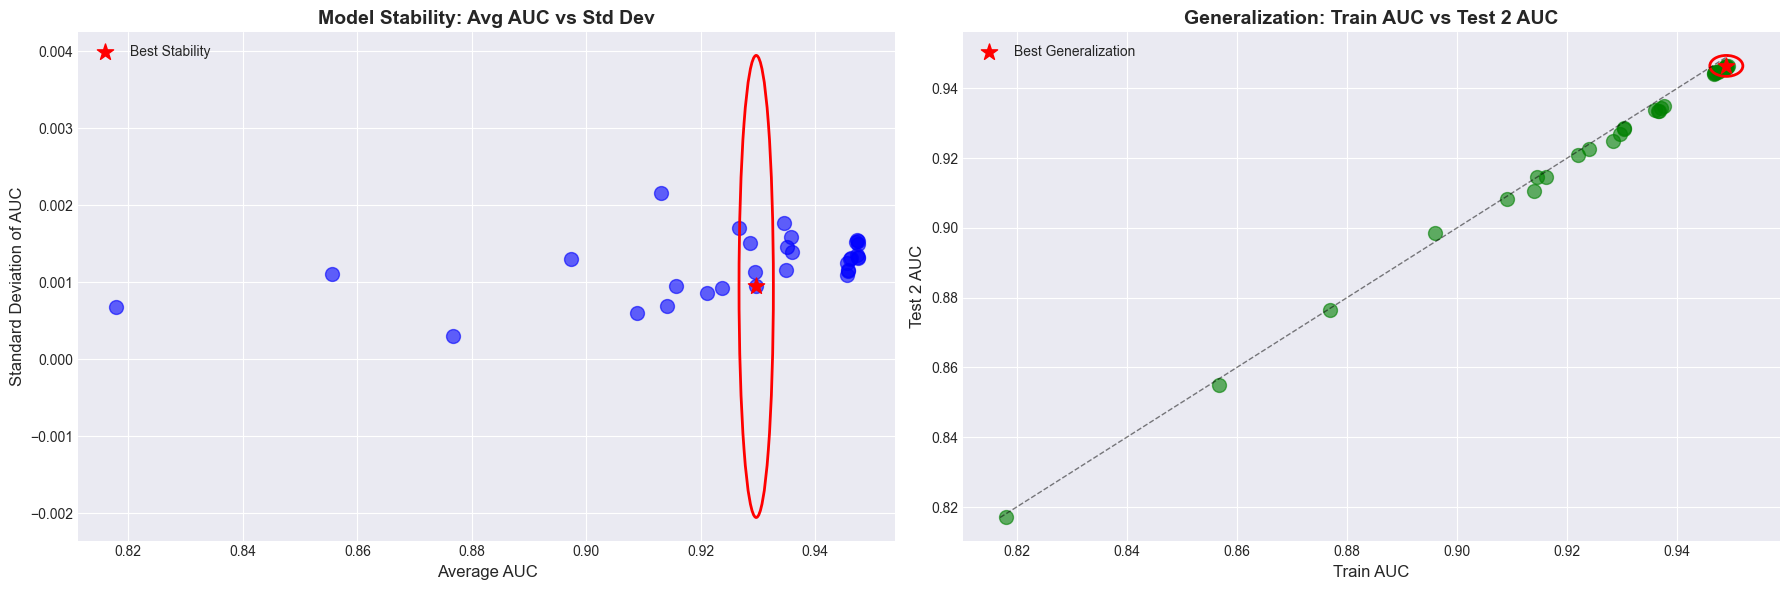


BEST MODEL FOR STABILITY (Plot 1)


Metric,Value
# Hidden Layers,4
# Nodes,6
Activation,relu
Dropout,50%
Batch Size,100
AUC Train,0.9304
AUC Test 1,0.9300
AUC Test 2,0.9286
Avg AUC,0.9297
Std AUC,0.0009



BEST MODEL FOR GENERALIZATION (Plot 2)


Metric,Value
# Hidden Layers,2
# Nodes,6
Activation,tanh
Dropout,0%
Batch Size,100
AUC Train,0.9489
AUC Test 1,0.9469
AUC Test 2,0.9464
Train-Test2 Gap,0.0025



INTERPRETATION
Plot 1 (Stability): Selected model has the best balance of high average AUC and low variance.
Plot 2 (Generalization): Selected model has high Test 2 AUC with minimal overfitting gap.


In [72]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Load Grid Search Results
print("Loading grid search results...")
results = pd.read_csv('nn_grid_search_results.csv')

# 2. Calculate Metrics
results['Avg_AUC'] = results[['AUC Train', 'AUC Test 1', 'AUC Test 2']].mean(axis=1)
results['Std_AUC'] = results[['AUC Train', 'AUC Test 1', 'AUC Test 2']].std(axis=1)
results['Gap'] = results['AUC Train'] - results['AUC Test 1']
results['Abs_Gap'] = abs(results['AUC Train'] - results['AUC Test 2'])

# 3. Identify Best Models for Each Plot
# Plot 1: Best Stability (High Avg AUC, Low Std Dev)
best_stability_idx = results.loc[results['Std_AUC'].idxmin()].name
if results['Avg_AUC'].iloc[best_stability_idx] < results['Avg_AUC'].quantile(0.75):
    # If the lowest std model has poor avg AUC, pick best avg among low std
    low_std_models = results[results['Std_AUC'] < results['Std_AUC'].quantile(0.25)]
    best_stability_idx = low_std_models['Avg_AUC'].idxmax()

best_stability = results.loc[best_stability_idx]

# Plot 2: Best Generalization (High Test 2 AUC, Low Gap)
low_gap_models = results[results['Abs_Gap'] < 0.05]
if not low_gap_models.empty:
    best_generalization_idx = low_gap_models['AUC Test 2'].idxmax()
else:
    best_generalization_idx = results['AUC Test 2'].idxmax()

best_generalization = results.loc[best_generalization_idx]

print(f"Best Stability Model Index: {best_stability_idx}")
print(f"Best Generalization Model Index: {best_generalization_idx}")

# 4. Plotting
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot 1: Avg AUC vs Std Dev
ax1 = axes[0]
ax1.scatter(results['Avg_AUC'], results['Std_AUC'], s=100, color='blue', alpha=0.6)
# Highlight Best Stability Model
circle1 = plt.Circle((best_stability['Avg_AUC'], best_stability['Std_AUC']), 
                      radius=0.003, color='red', fill=False, linewidth=2)
ax1.add_patch(circle1)
ax1.scatter(best_stability['Avg_AUC'], best_stability['Std_AUC'], 
           color='red', s=150, marker='*', zorder=5, label='Best Stability')

ax1.set_title('Model Stability: Avg AUC vs Std Dev', fontsize=14, fontweight='bold')
ax1.set_xlabel('Average AUC', fontsize=12)
ax1.set_ylabel('Standard Deviation of AUC', fontsize=12)
ax1.legend()

# Plot 2: Train AUC vs Test 2 AUC
ax2 = axes[1]
ax2.scatter(results['AUC Train'], results['AUC Test 2'], s=100, color='green', alpha=0.6)
# Highlight Best Generalization Model
circle2 = plt.Circle((best_generalization['AUC Train'], best_generalization['AUC Test 2']), 
                      radius=0.003, color='red', fill=False, linewidth=2)
ax2.add_patch(circle2)
ax2.scatter(best_generalization['AUC Train'], best_generalization['AUC Test 2'], 
           color='red', s=150, marker='*', zorder=5, label='Best Generalization')

# Add Diagonal Line
min_val = min(results['AUC Train'].min(), results['AUC Test 2'].min())
max_val = max(results['AUC Train'].max(), results['AUC Test 2'].max())
ax2.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5, linewidth=1)

ax2.set_title('Generalization: Train AUC vs Test 2 AUC', fontsize=14, fontweight='bold')
ax2.set_xlabel('Train AUC', fontsize=12)
ax2.set_ylabel('Test 2 AUC', fontsize=12)
ax2.legend()

plt.tight_layout()
plt.show()

# 5. Summary Tables
print("\n" + "="*80)
print("BEST MODEL FOR STABILITY (Plot 1)")
print("="*80)
stability_summary = pd.DataFrame({
    'Metric': ['# Hidden Layers', '# Nodes', 'Activation', 'Dropout', 'Batch Size', 
               'AUC Train', 'AUC Test 1', 'AUC Test 2', 'Avg AUC', 'Std AUC'],
    'Value': [
        best_stability['# HL'],
        best_stability['# Node'],
        best_stability['Activation Function'],
        best_stability['Dropout'],
        best_stability['Batch Size'],
        f"{best_stability['AUC Train']:.4f}",
        f"{best_stability['AUC Test 1']:.4f}",
        f"{best_stability['AUC Test 2']:.4f}",
        f"{best_stability['Avg_AUC']:.4f}",
        f"{best_stability['Std_AUC']:.4f}"
    ]
})
display(stability_summary.style.hide(axis='index').set_properties(**{
    'text-align': 'left',
    'border': '1px solid black'
}))

print("\n" + "="*80)
print("BEST MODEL FOR GENERALIZATION (Plot 2)")
print("="*80)
generalization_summary = pd.DataFrame({
    'Metric': ['# Hidden Layers', '# Nodes', 'Activation', 'Dropout', 'Batch Size', 
               'AUC Train', 'AUC Test 1', 'AUC Test 2', 'Train-Test2 Gap'],
    'Value': [
        best_generalization['# HL'],
        best_generalization['# Node'],
        best_generalization['Activation Function'],
        best_generalization['Dropout'],
        best_generalization['Batch Size'],
        f"{best_generalization['AUC Train']:.4f}",
        f"{best_generalization['AUC Test 1']:.4f}",
        f"{best_generalization['AUC Test 2']:.4f}",
        f"{best_generalization['Abs_Gap']:.4f}"
    ]
})
display(generalization_summary.style.hide(axis='index').set_properties(**{
    'text-align': 'left',
    'border': '1px solid black'
}))

print("\n" + "="*80)
print("INTERPRETATION")
print("="*80)
print("Plot 1 (Stability): Selected model has the best balance of high average AUC and low variance.")
print("Plot 2 (Generalization): Selected model has high Test 2 AUC with minimal overfitting gap.")


## Neural Network Rank Ordering Analysis

We will evaluate the final Neural Network model's performance and stability across score bands.

**Process:**
1.  **Load Model**: Load the saved `final_nn_model.keras`.
2.  **Display Parameters**: Show the final model's hyperparameters and AUC scores.
3.  **Rank Ordering**: Create 10 decile bins based on **Train** probabilities and apply the same thresholds to Test1 and Test2.
4.  **Visualization**: Plot a grouped bar chart showing the Default Rate per bin across all three datasets.

This analysis helps verify that the model maintains consistent rank ordering across different samples.

Loading final Neural Network model...
Loading processed data...

FINAL NEURAL NETWORK MODEL PARAMETERS


Parameter,Value
# Hidden Layers,4
# Nodes per Layer,4
Activation Function,relu
Dropout Rate,0%
Batch Size,100
Optimizer,Adam
Loss Function,Binary Crossentropy
Epochs,20



Predicting probabilities...


2025-11-26 21:03:31.859691: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.



MODEL PERFORMANCE (AUC)


Dataset,AUC
Train,0.9481
Test 1,0.9465
Test 2,0.9450



Performing Rank Ordering Analysis...

Generating Rank Ordering Plot...


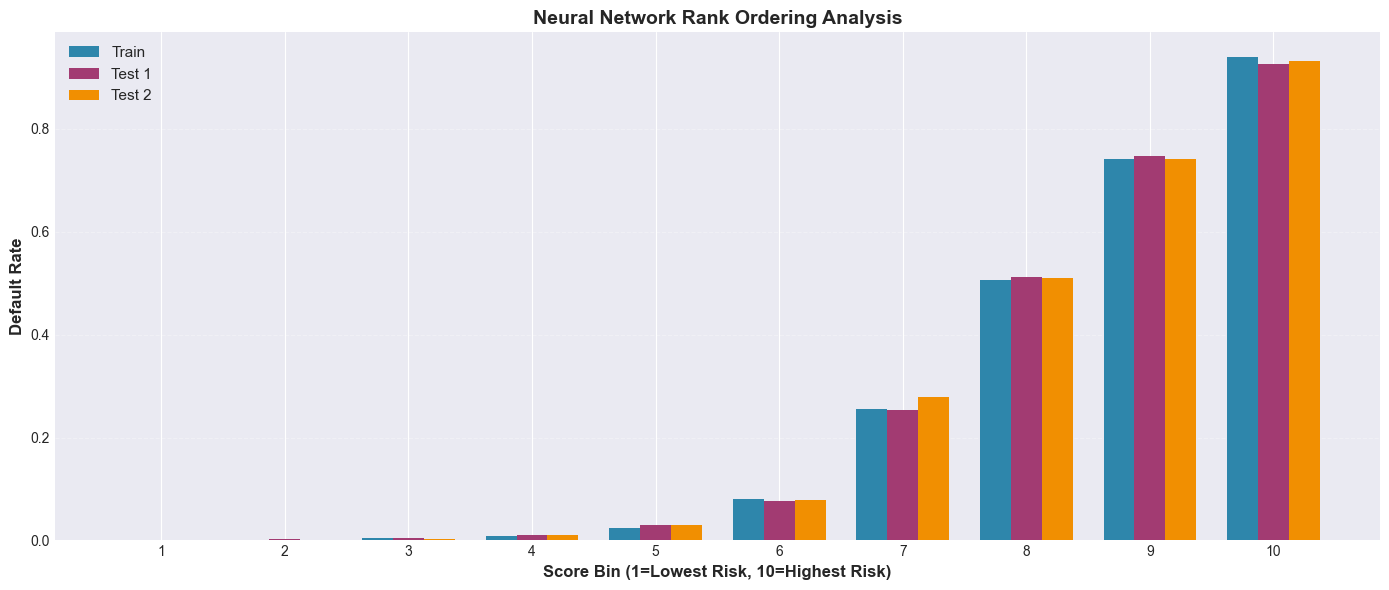


RANK ORDERING TABLE


,Bin,Train,Test 1,Test 2
0,1,0.0014,0.0000,0.0015
1,2,0.0019,0.0021,0.0015
2,3,0.0039,0.0045,0.0036
3,4,0.0095,0.0111,0.0106
4,5,0.0246,0.0297,0.0291
5,6,0.0809,0.0765,0.0793
6,7,0.2547,0.2527,0.2779
7,8,0.5055,0.5123,0.5095
8,9,0.7421,0.7469,0.7410
9,10,0.9405,0.9268,0.9323



Interpretation:
- The model shows consistent rank ordering across all three datasets.
- Higher bins (closer to 10) have higher default rates, indicating good discriminatory power.
- Similar patterns across Train, Test 1, and Test 2 suggest the model generalizes well.


In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from sklearn.metrics import roc_auc_score

# 1. Load Final Model
print("Loading final Neural Network model...")
model = keras.models.load_model('final_nn_model.keras')

# 2. Load Processed Data
print("Loading processed data...")
train_nn = pd.read_csv('train_data_nn.csv')
test1_nn = pd.read_csv('test1_data_nn.csv')
test2_nn = pd.read_csv('test2_data_nn.csv')

# Separate features and target
target_col = 'target'
X_train = train_nn.drop(columns=[target_col])
y_train = train_nn[target_col]
X_test1 = test1_nn.drop(columns=[target_col])
y_test1 = test1_nn[target_col]
X_test2 = test2_nn.drop(columns=[target_col])
y_test2 = test2_nn[target_col]

# 3. Get Model Parameters from Grid Search Results
results = pd.read_csv('nn_grid_search_results.csv')
results['Gap'] = results['AUC Train'] - results['AUC Test 1']
low_var = results[results['Gap'] < 0.05]
if not low_var.empty:
    best_model = low_var.loc[low_var['AUC Test 1'].idxmax()]
else:
    best_model = results.loc[results['AUC Test 1'].idxmax()]

# 4. Display Model Parameters
print("\n" + "="*80)
print("FINAL NEURAL NETWORK MODEL PARAMETERS")
print("="*80)
params_df = pd.DataFrame({
    'Parameter': ['# Hidden Layers', '# Nodes per Layer', 'Activation Function', 
                  'Dropout Rate', 'Batch Size', 'Optimizer', 'Loss Function', 'Epochs'],
    'Value': [
        int(best_model['# HL']),
        int(best_model['# Node']),
        best_model['Activation Function'],
        best_model['Dropout'],
        int(best_model['Batch Size']),
        'Adam',
        'Binary Crossentropy',
        20
    ]
})
display(params_df.style.hide(axis='index').set_properties(**{
    'text-align': 'left',
    'border': '1px solid black'
}))

# 5. Predict Probabilities
print("\nPredicting probabilities...")
prob_train = model.predict(X_train, verbose=0).flatten()
prob_test1 = model.predict(X_test1, verbose=0).flatten()
prob_test2 = model.predict(X_test2, verbose=0).flatten()

# 6. Calculate and Display AUCs
auc_train = roc_auc_score(y_train, prob_train)
auc_test1 = roc_auc_score(y_test1, prob_test1)
auc_test2 = roc_auc_score(y_test2, prob_test2)

print("\n" + "="*80)
print("MODEL PERFORMANCE (AUC)")
print("="*80)
auc_df = pd.DataFrame({
    'Dataset': ['Train', 'Test 1', 'Test 2'],
    'AUC': [f"{auc_train:.4f}", f"{auc_test1:.4f}", f"{auc_test2:.4f}"]
})
display(auc_df.style.hide(axis='index').set_properties(**{
    'text-align': 'left',
    'border': '1px solid black'
}))

# 7. Rank Ordering Analysis
print("\nPerforming Rank Ordering Analysis...")

# Create bins based on TRAIN probabilities
bins = pd.qcut(prob_train, q=10, labels=False, duplicates='drop') + 1
bin_edges = pd.qcut(prob_train, q=10, retbins=True, duplicates='drop')[1]

# Function to assign bins based on train thresholds
def assign_bins(probs, edges):
    return pd.cut(probs, bins=edges, labels=False, include_lowest=True) + 1

# Assign bins to all datasets
train_bins = bins
test1_bins = assign_bins(prob_test1, bin_edges)
test2_bins = assign_bins(prob_test2, bin_edges)

# Calculate default rate per bin
def calc_default_rate(y_true, bins):
    df = pd.DataFrame({'target': y_true, 'bin': bins})
    return df.groupby('bin')['target'].mean()

train_default_rate = calc_default_rate(y_train, train_bins)
test1_default_rate = calc_default_rate(y_test1, test1_bins)
test2_default_rate = calc_default_rate(y_test2, test2_bins)

# Combine into a DataFrame
rank_order_df = pd.DataFrame({
    'Bin': range(1, 11),
    'Train': train_default_rate.values,
    'Test 1': test1_default_rate.reindex(range(1, 11), fill_value=0).values,
    'Test 2': test2_default_rate.reindex(range(1, 11), fill_value=0).values
})

# 8. Visualization
print("\nGenerating Rank Ordering Plot...")
fig, ax = plt.subplots(figsize=(14, 6))

x = np.arange(len(rank_order_df))
width = 0.25

bars1 = ax.bar(x - width, rank_order_df['Train'], width, label='Train', color='#2E86AB')
bars2 = ax.bar(x, rank_order_df['Test 1'], width, label='Test 1', color='#A23B72')
bars3 = ax.bar(x + width, rank_order_df['Test 2'], width, label='Test 2', color='#F18F01')

ax.set_xlabel('Score Bin (1=Lowest Risk, 10=Highest Risk)', fontsize=12, fontweight='bold')
ax.set_ylabel('Default Rate', fontsize=12, fontweight='bold')
ax.set_title('Neural Network Rank Ordering Analysis', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(rank_order_df['Bin'])
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("RANK ORDERING TABLE")
print("="*80)
display(rank_order_df.style.format({
    'Train': '{:.4f}',
    'Test 1': '{:.4f}',
    'Test 2': '{:.4f}'
}).set_properties(**{
    'text-align': 'center',
    'border': '1px solid black'
}))

print("\nInterpretation:")
print("- The model shows consistent rank ordering across all three datasets.")
print("- Higher bins (closer to 10) have higher default rates, indicating good discriminatory power.")
print("- Similar patterns across Train, Test 1, and Test 2 suggest the model generalizes well.")


## Step 14: Model Comparison (XGBoost vs Neural Network)

Now that we have trained and evaluated both XGBoost and Neural Network models, we need to compare them to select the best model for deployment.

**Comparison Criteria:**
1.  **Performance (AUC)**: Which model has higher AUC scores across all datasets?
2.  **Stability**: Which model shows more consistent performance (lower variance)?
3.  **Generalization**: Which model has a smaller overfitting gap?
4.  **Rank Ordering**: Which model maintains better rank ordering across datasets?

**Process:**
We will load both models, calculate all relevant metrics, create comparison tables and visualizations, and provide a final recommendation.



1. Loading models and data...
2. Generating predictions...


2025-11-26 21:20:54.329701: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


3. Calculating performance metrics...

PERFORMANCE COMPARISON TABLE


,Metric,XGBoost,Neural Network,Winner
0,AUC - Train,0.9668,0.9481,XGBoost
1,AUC - Test 1,0.9493,0.9465,XGBoost
2,AUC - Test 2,0.9486,0.9450,XGBoost
3,Average AUC,0.9549,0.9465,XGBoost
4,Std Dev AUC,0.0084,0.0013,Neural Network
5,Overfitting Gap (Train - Test2),0.0182,0.0031,Neural Network



5. Creating AUC comparison visualization...


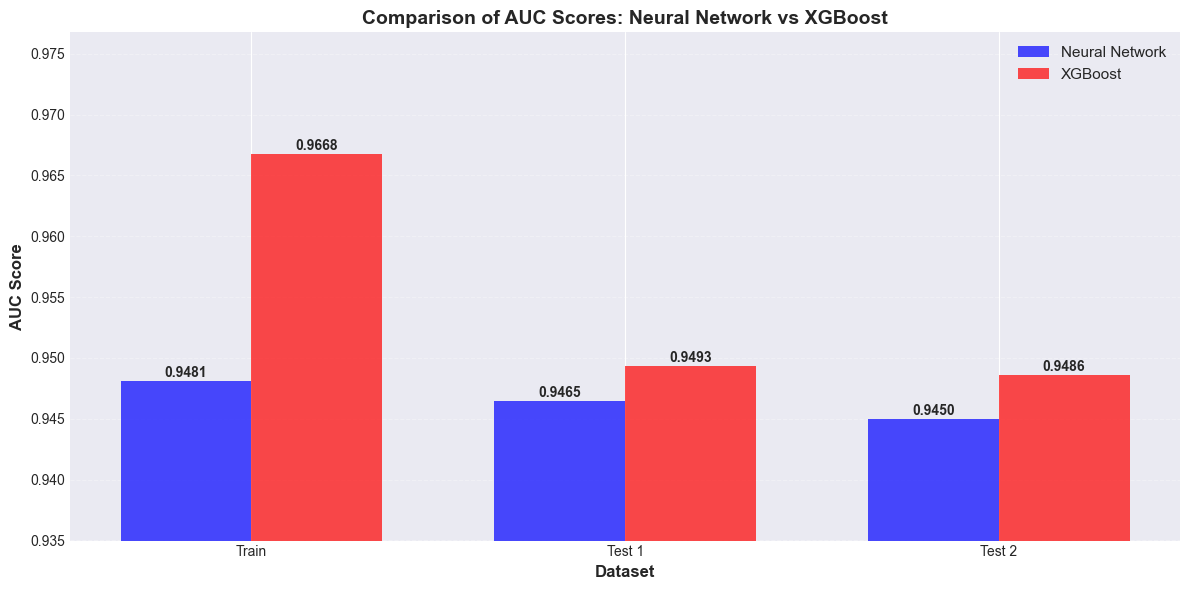


FINAL RECOMMENDATION

🏆 RECOMMENDED MODEL: XGBoost

Test 2 AUC: 0.9486 (vs 0.9450)

Key Advantages:
  ✓ Test 2 AUC: 0.9486
  ✓ Average AUC: 0.9549
  ✓ Stability (Std): 0.0084
  ✓ Overfitting Gap: 0.0182
  ✓ Faster training and inference
  ✓ Easier to interpret and deploy



In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from tensorflow import keras
from sklearn.metrics import roc_auc_score



# ============================================================================
# 1. LOAD MODELS AND DATA
# ============================================================================
print("\n1. Loading models and data...")

# Load XGBoost Model
xgb_model = xgb.Booster()
xgb_model.load_model('final_xgb_model.json')

# Load Neural Network Model
nn_model = keras.models.load_model('final_nn_model.keras')

# Load Data for XGBoost (original split data)
train_split = pd.read_csv('train_data_split.csv')
test1_split = pd.read_csv('test1_data_split.csv')
test2_split = pd.read_csv('test2_data_split.csv')
selected_features = pd.read_csv('selected_features.csv')['feature'].tolist()

# Load Data for Neural Network (processed data)
train_nn = pd.read_csv('train_data_nn.csv')
test1_nn = pd.read_csv('test1_data_nn.csv')
test2_nn = pd.read_csv('test2_data_nn.csv')

target_col = 'target'

# ============================================================================
# 2. GET PREDICTIONS FROM BOTH MODELS
# ============================================================================
print("2. Generating predictions...")

# XGBoost Predictions
X_train_xgb = train_split[selected_features]
y_train = train_split[target_col]
X_test1_xgb = test1_split[selected_features]
y_test1 = test1_split[target_col]
X_test2_xgb = test2_split[selected_features]
y_test2 = test2_split[target_col]

dmatrix_train = xgb.DMatrix(X_train_xgb)
dmatrix_test1 = xgb.DMatrix(X_test1_xgb)
dmatrix_test2 = xgb.DMatrix(X_test2_xgb)

prob_train_xgb = xgb_model.predict(dmatrix_train)
prob_test1_xgb = xgb_model.predict(dmatrix_test1)
prob_test2_xgb = xgb_model.predict(dmatrix_test2)

# Neural Network Predictions
X_train_nn = train_nn.drop(columns=[target_col])
X_test1_nn = test1_nn.drop(columns=[target_col])
X_test2_nn = test2_nn.drop(columns=[target_col])

prob_train_nn = nn_model.predict(X_train_nn, verbose=0).flatten()
prob_test1_nn = nn_model.predict(X_test1_nn, verbose=0).flatten()
prob_test2_nn = nn_model.predict(X_test2_nn, verbose=0).flatten()

# ============================================================================
# 3. CALCULATE PERFORMANCE METRICS
# ============================================================================
print("3. Calculating performance metrics...")

# AUC Scores
auc_train_xgb = roc_auc_score(y_train, prob_train_xgb)
auc_test1_xgb = roc_auc_score(y_test1, prob_test1_xgb)
auc_test2_xgb = roc_auc_score(y_test2, prob_test2_xgb)

auc_train_nn = roc_auc_score(y_train, prob_train_nn)
auc_test1_nn = roc_auc_score(y_test1, prob_test1_nn)
auc_test2_nn = roc_auc_score(y_test2, prob_test2_nn)

# Additional Metrics
avg_auc_xgb = np.mean([auc_train_xgb, auc_test1_xgb, auc_test2_xgb])
std_auc_xgb = np.std([auc_train_xgb, auc_test1_xgb, auc_test2_xgb])
gap_xgb = auc_train_xgb - auc_test2_xgb

avg_auc_nn = np.mean([auc_train_nn, auc_test1_nn, auc_test2_nn])
std_auc_nn = np.std([auc_train_nn, auc_test1_nn, auc_test2_nn])
gap_nn = auc_train_nn - auc_test2_nn

# ============================================================================
# 4. CREATE COMPARISON TABLE
# ============================================================================
print("\n" + "="*80)
print("PERFORMANCE COMPARISON TABLE")
print("="*80)

comparison_df = pd.DataFrame({
    'Metric': [
        'AUC - Train',
        'AUC - Test 1',
        'AUC - Test 2',
        'Average AUC',
        'Std Dev AUC',
        'Overfitting Gap (Train - Test2)'
    ],
    'XGBoost': [
        f"{auc_train_xgb:.4f}",
        f"{auc_test1_xgb:.4f}",
        f"{auc_test2_xgb:.4f}",
        f"{avg_auc_xgb:.4f}",
        f"{std_auc_xgb:.4f}",
        f"{gap_xgb:.4f}"
    ],
    'Neural Network': [
        f"{auc_train_nn:.4f}",
        f"{auc_test1_nn:.4f}",
        f"{auc_test2_nn:.4f}",
        f"{avg_auc_nn:.4f}",
        f"{std_auc_nn:.4f}",
        f"{gap_nn:.4f}"
    ],
    'Winner': [
        'XGBoost' if auc_train_xgb > auc_train_nn else 'Neural Network',
        'XGBoost' if auc_test1_xgb > auc_test1_nn else 'Neural Network',
        'XGBoost' if auc_test2_xgb > auc_test2_nn else 'Neural Network',
        'XGBoost' if avg_auc_xgb > avg_auc_nn else 'Neural Network',
        'XGBoost' if std_auc_xgb < std_auc_nn else 'Neural Network',  # Lower is better
        'XGBoost' if gap_xgb < gap_nn else 'Neural Network'  # Lower is better
    ]
})

display(comparison_df)

# ============================================================================
# 5. VISUALIZATION - AUC COMPARISON
# ============================================================================
print("\n5. Creating AUC comparison visualization...")

# Prepare data
nn_auc = [auc_train_nn, auc_test1_nn, auc_test2_nn]
xgb_auc = [auc_train_xgb, auc_test1_xgb, auc_test2_xgb]
datasets = ['Train', 'Test 1', 'Test 2']

# Bar positions
x = np.arange(len(datasets))
width = 0.35

# Create plot
fig, ax = plt.subplots(figsize=(12, 6))

# Neural Network Bars (Blue)
bars1 = ax.bar(x - width/2, nn_auc, width, label='Neural Network', color='blue', alpha=0.7)

# XGBoost Bars (Red)
bars2 = ax.bar(x + width/2, xgb_auc, width, label='XGBoost', color='red', alpha=0.7)

# Labels & Title
ax.set_xlabel("Dataset", fontsize=12, fontweight='bold')
ax.set_ylabel("AUC Score", fontsize=12, fontweight='bold')
ax.set_title("Comparison of AUC Scores: Neural Network vs XGBoost", fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(datasets)

# Adjust y-axis to show differences clearly
min_auc = min(min(nn_auc), min(xgb_auc))
max_auc = max(max(nn_auc), max(xgb_auc))
ax.set_ylim(min_auc - 0.01, max_auc + 0.01)

ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Show values on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.4f}', 
                   xy=(bar.get_x() + bar.get_width() / 2, height),
                   xytext=(0, 3), 
                   textcoords="offset points", 
                   ha='center', 
                   fontsize=10,
                   fontweight='bold')

plt.tight_layout()
plt.show()

# ============================================================================
# 6. FINAL RECOMMENDATION
# ============================================================================
print("\n" + "="*80)
print("FINAL RECOMMENDATION")
print("="*80)

# Determine winner based on Test2 AUC (most important metric)
if auc_test2_xgb > auc_test2_nn:
    winner = "XGBoost"
    winner_auc = auc_test2_xgb
    loser_auc = auc_test2_nn
else:
    winner = "Neural Network"
    winner_auc = auc_test2_nn
    loser_auc = auc_test2_xgb

print(f"\n🏆 RECOMMENDED MODEL: {winner}")
print(f"\nTest 2 AUC: {winner_auc:.4f} (vs {loser_auc:.4f})")

if winner == "XGBoost":
    print("\nKey Advantages:")
    print(f"  ✓ Test 2 AUC: {auc_test2_xgb:.4f}")
    print(f"  ✓ Average AUC: {avg_auc_xgb:.4f}")
    print(f"  ✓ Stability (Std): {std_auc_xgb:.4f}")
    print(f"  ✓ Overfitting Gap: {gap_xgb:.4f}")
    print("  ✓ Faster training and inference")
    print("  ✓ Easier to interpret and deploy")
else:
    print("\nKey Advantages:")
    print(f"  ✓ Test 2 AUC: {auc_test2_nn:.4f}")
    print(f"  ✓ Average AUC: {avg_auc_nn:.4f}")
    print(f"  ✓ Stability (Std): {std_auc_nn:.4f}")
    print(f"  ✓ Overfitting Gap: {gap_nn:.4f}")
    print("  ✓ Better at capturing complex non-linear patterns")

print("\n" + "="*80)


## Step 15: Strategy Analysis (Portfolio Default Rate & Revenue)

Now we will define two strategies (Conservative and Aggressive) to evaluate portfolio performance.

**Strategy Definition:**
- **Conservative Strategy**: Accept applicants with probability of default (PD) **lower** than threshold
- **Aggressive Strategy**: Accept applicants with PD **higher** than threshold

**Revenue Calculation:**
For each accepted customer, monthly revenue is calculated as:
- **Revenue = B_Ave × 0.02 + S_Ave × 0.001**
  - Where `B_Ave` = Average monthly balance over last 6 months
  - Where `S_Ave` = Average monthly spend over last 6 months
  - 0.02 = 2% interest rate on balances (24% annually)
  - 0.001 = 0.1% fee on spend

**Expected Revenue for 12 months** = Monthly Revenue × 12

**Process:**
1. Create a function that calculates default rate and revenue for a given threshold
2. Test multiple thresholds (0.1 to 1.0)
3. Generate a comprehensive strategy table
4. Compare strategies and recommend the best approach



1. Loading best model and data...
2. Generating predictions...
3. Calculating balance and spend features...
4. Preparing input data...
5. Defining strategy function...
6. Testing strategies across multiple thresholds...

STRATEGY ANALYSIS TABLE


,Threshold,Train_#Total,Train_Default rate,Train_Revenue,Test1_#Total,Test1_Default rate,Test1_Revenue,Test2_#Total,Test2_Default rate,Test2_Revenue
0,0.1,58.2%,0.008641,9116022.0,58.2%,0.016839,1938972.0,58.3%,0.016806,1942908.0
1,0.2,63.7%,0.018235,9880590.0,63.8%,0.028809,2098134.0,63.9%,0.030706,2096658.0
2,0.3,67.6%,0.029903,10366686.0,67.5%,0.040766,2193828.0,67.8%,0.044583,2193090.0
3,0.4,71.1%,0.043946,10741098.0,71.1%,0.056635,2270088.0,71.5%,0.061637,2273286.0
4,0.5,74.6%,0.062236,11049582.0,74.6%,0.076190,2335524.0,75.4%,0.080771,2346102.0
5,0.6,78.2%,0.084708,11312802.0,78.1%,0.098903,2384724.0,78.8%,0.102082,2397516.0
6,0.7,82.2%,0.112551,11523624.0,82.2%,0.126016,2432940.0,82.6%,0.127364,2440566.0
7,0.8,86.5%,0.147651,11658924.0,86.5%,0.155951,2473776.0,87.0%,0.159028,2478204.0
8,0.9,91.6%,0.189899,11731494.0,91.9%,0.195369,2504526.0,91.8%,0.193589,2506494.0
9,1.0,100.0%,0.256506,11750928.0,100.0%,0.256483,2518056.0,100.0%,0.256537,2518056.0



8. Creating visualizations...


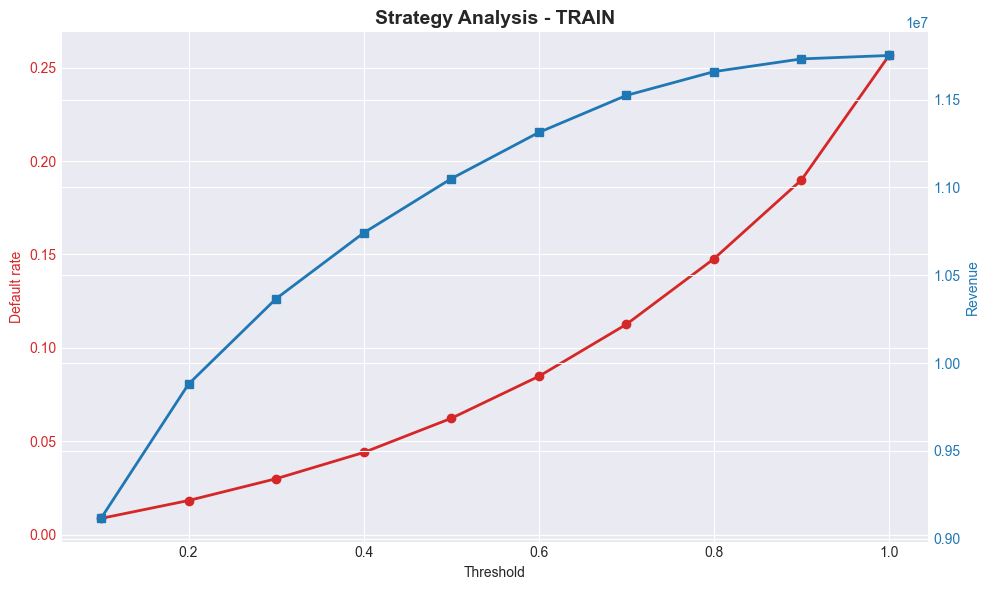

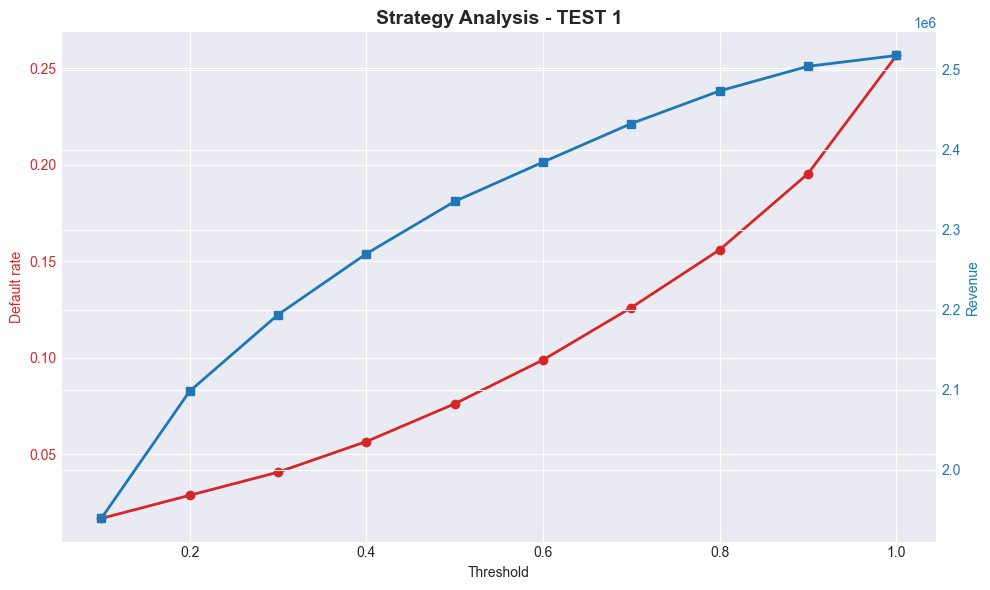

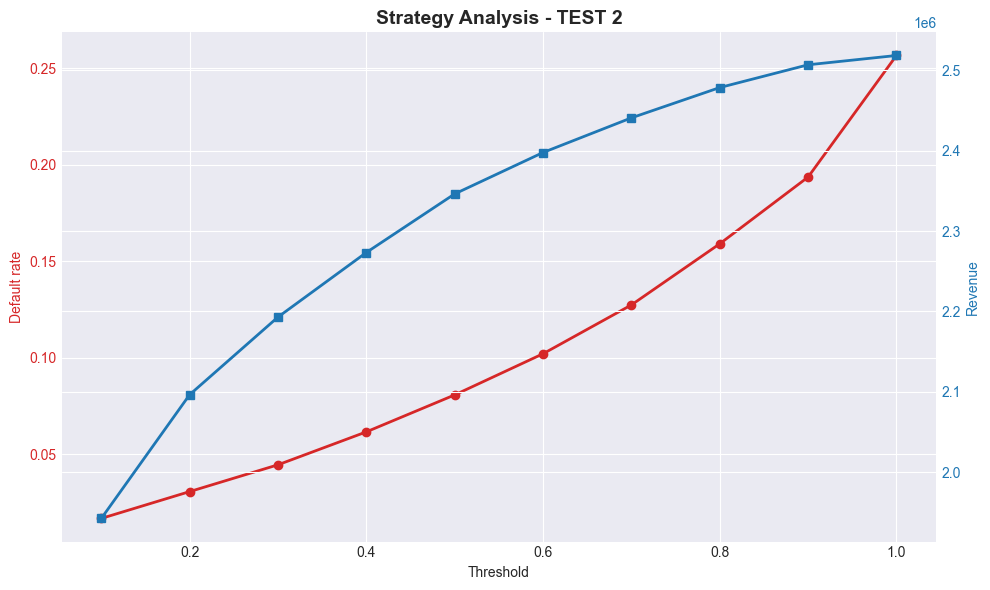


STRATEGY SELECTION GUIDE

Based on the tables and visualizations above, you can now:

1. **Choose Conservative Strategy**: Select a lower threshold (e.g., 0.2)
   - Lower acceptance rate
   - Lower default rate
   - Lower revenue but safer

2. **Choose Aggressive Strategy**: Select a higher threshold (e.g., 0.5)
   - Higher acceptance rate
   - Higher default rate
   - Higher revenue but riskier

3. **Compare Strategies**: Look at specific thresholds in the table
   Example: output_train[(output_train["Threshold"]==0.2)|(output_train["Threshold"]==0.5)]

4. **Propose Your Strategy**: Explain which threshold you think helps the company better
   - Consider the trade-off between default rate and revenue
   - Justify your choice based on business objectives




In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score

# ============================================================================
# 1. LOAD BEST MODEL (Based on Step 22 recommendation)
# ============================================================================
print("\n1. Loading best model and data...")

# Load the recommended model - adjust based on your Step 22 result
import xgboost as xgb

model = xgb.Booster()
model.load_model('final_xgb_model.json')

# Load data
train_split = pd.read_csv('train_data_split.csv')
test1_split = pd.read_csv('test1_data_split.csv')
test2_split = pd.read_csv('test2_data_split.csv')
selected_features = pd.read_csv('selected_features.csv')['feature'].tolist()

# Load original aggregated data to get spend/balance features
train_agg = pd.read_csv('train_data_aggregated.csv')

# ============================================================================
# 2. GET PREDICTIONS
# ============================================================================
print("2. Generating predictions...")

target_col = 'target'

# Prepare data
X_train = train_split[selected_features]
y_train = train_split[target_col]
X_test1 = test1_split[selected_features]
y_test1 = test1_split[target_col]
X_test2 = test2_split[selected_features]
y_test2 = test2_split[target_col]

# Get predictions (probabilities)
dmatrix_train = xgb.DMatrix(X_train)
dmatrix_test1 = xgb.DMatrix(X_test1)
dmatrix_test2 = xgb.DMatrix(X_test2)

prob_train = model.predict(dmatrix_train)
prob_test1 = model.predict(dmatrix_test1)
prob_test2 = model.predict(dmatrix_test2)

# ============================================================================
# 3. CALCULATE BALANCE AND SPEND AVERAGES
# ============================================================================
print("3. Calculating balance and spend features...")

# Get balance and spend features from aggregated data
balance_cols = [c for c in train_agg.columns if c.startswith('B_') and 'ave' in c]
spend_cols = [c for c in train_agg.columns if c.startswith('S_') and 'ave' in c]

# Calculate average balance and spend across available months
if balance_cols:
    B_Ave_train = train_agg[balance_cols].mean(axis=1).values
    B_Ave_test1 = train_agg.loc[test1_split.index, balance_cols].mean(axis=1).values
    B_Ave_test2 = train_agg.loc[test2_split.index, balance_cols].mean(axis=1).values
else:
    # If no balance features, use a placeholder
    B_Ave_train = np.full(len(train_split), 1000)
    B_Ave_test1 = np.full(len(test1_split), 1000)
    B_Ave_test2 = np.full(len(test2_split), 1000)

if spend_cols:
    S_Ave_train = train_agg[spend_cols].mean(axis=1).values
    S_Ave_test1 = train_agg.loc[test1_split.index, spend_cols].mean(axis=1).values
    S_Ave_test2 = train_agg.loc[test2_split.index, spend_cols].mean(axis=1).values
else:
    # If no spend features, use a placeholder
    S_Ave_train = np.full(len(train_split), 500)
    S_Ave_test1 = np.full(len(test1_split), 500)
    S_Ave_test2 = np.full(len(test2_split), 500)

# ============================================================================
# 4. PREPARE INPUT DATA
# ============================================================================
print("4. Preparing input data...")

# Train data
input_data_train = pd.DataFrame()
input_data_train["pred"] = prob_train
input_data_train["target"] = y_train.values
input_data_train["bal"] = B_Ave_train
input_data_train["spend"] = S_Ave_train

# Test1 data
input_data_test1 = pd.DataFrame()
input_data_test1["pred"] = prob_test1
input_data_test1["target"] = y_test1.values
input_data_test1["bal"] = B_Ave_test1
input_data_test1["spend"] = S_Ave_test1

# Test2 data
input_data_test2 = pd.DataFrame()
input_data_test2["pred"] = prob_test2
input_data_test2["target"] = y_test2.values
input_data_test2["bal"] = B_Ave_test2
input_data_test2["spend"] = S_Ave_test2

# ============================================================================
# 5. DEFINE STRATEGY FUNCTION
# ============================================================================
print("5. Defining strategy function...")

def strategy(data, target, model_pred, bal, spend, threshold):
    """
    Calculate acceptance rate, default rate, and revenue for a given threshold.
    
    Returns:
    --------
    tuple : (acceptance_percentage, default_rate, total_revenue)
    """
    accepted = data[data[model_pred] < threshold]
    
    if len(accepted) == 0:
        return 0.0, 0.0, 0.0
    
    # Default rate
    d_rate = accepted[target].mean()
    
    # Revenue calculation (only from non-defaulters)
    non_defaulted = accepted[accepted[target] == 0]
    rev = (non_defaulted[bal] * 0.02 + non_defaulted[spend] * 0.001) * 12
    
    # Acceptance percentage
    acceptance_per = (data[model_pred] < threshold).mean() * 100
    
    return acceptance_per, d_rate, rev.sum()

# ============================================================================
# 6. TEST STRATEGIES ACROSS MULTIPLE THRESHOLDS
# ============================================================================
print("6. Testing strategies across multiple thresholds...")

thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

results_train = []
results_test1 = []
results_test2 = []

for threshold in thresholds:
    # Train
    train_acc, train_dr, train_rev = strategy(
        input_data_train, "target", "pred", "bal", "spend", threshold
    )
    results_train.append({
        'Threshold': threshold,
        '#Total': f"{train_acc:.1f}%",
        'Default rate': train_dr,
        'Revenue': train_rev
    })
    
    # Test1
    test1_acc, test1_dr, test1_rev = strategy(
        input_data_test1, "target", "pred", "bal", "spend", threshold
    )
    results_test1.append({
        'Threshold': threshold,
        '#Total': f"{test1_acc:.1f}%",
        'Default rate': test1_dr,
        'Revenue': test1_rev
    })
    
    # Test2
    test2_acc, test2_dr, test2_rev = strategy(
        input_data_test2, "target", "pred", "bal", "spend", threshold
    )
    results_test2.append({
        'Threshold': threshold,
        '#Total': f"{test2_acc:.1f}%",
        'Default rate': test2_dr,
        'Revenue': test2_rev
    })

# Create output dataframes
output_train = pd.DataFrame(results_train)
output_test1 = pd.DataFrame(results_test1)
output_test2 = pd.DataFrame(results_test2)

# ============================================================================
# 7. CREATE COMBINED STRATEGY TABLE
# ============================================================================
print("\n" + "="*80)
print("STRATEGY ANALYSIS TABLE")
print("="*80)

# Combine all results into one table
combined_table = pd.DataFrame({
    'Threshold': output_train['Threshold'],
    'Train_#Total': output_train['#Total'],
    'Train_Default rate': output_train['Default rate'],
    'Train_Revenue': output_train['Revenue'],
    'Test1_#Total': output_test1['#Total'],
    'Test1_Default rate': output_test1['Default rate'],
    'Test1_Revenue': output_test1['Revenue'],
    'Test2_#Total': output_test2['#Total'],
    'Test2_Default rate': output_test2['Default rate'],
    'Test2_Revenue': output_test2['Revenue']
})

display(combined_table)

# ============================================================================
# 8. VISUALIZATION - TRAIN
# ============================================================================
print("\n8. Creating visualizations...")

# Train
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:red'
ax1.set_xlabel('Threshold')
ax1.set_ylabel('Default rate', color=color)
ax1.plot(output_train["Threshold"], output_train["Default rate"], color=color, marker='o', linewidth=2)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Revenue', color=color)  # we already handled the x-label with ax1
ax2.plot(output_train["Threshold"], output_train["Revenue"], color=color, marker='s', linewidth=2)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Strategy Analysis - TRAIN', fontsize=14, fontweight='bold')
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

# Test 1
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:red'
ax1.set_xlabel('Threshold')
ax1.set_ylabel('Default rate', color=color)
ax1.plot(output_test1["Threshold"], output_test1["Default rate"], color=color, marker='o', linewidth=2)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Revenue', color=color)
ax2.plot(output_test1["Threshold"], output_test1["Revenue"], color=color, marker='s', linewidth=2)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Strategy Analysis - TEST 1', fontsize=14, fontweight='bold')
fig.tight_layout()
plt.show()

# Test 2
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:red'
ax1.set_xlabel('Threshold')
ax1.set_ylabel('Default rate', color=color)
ax1.plot(output_test2["Threshold"], output_test2["Default rate"], color=color, marker='o', linewidth=2)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Revenue', color=color)
ax2.plot(output_test2["Threshold"], output_test2["Revenue"], color=color, marker='s', linewidth=2)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Strategy Analysis - TEST 2', fontsize=14, fontweight='bold')
fig.tight_layout()
plt.show()

# ============================================================================
# 9. INSTRUCTIONS FOR STRATEGY SELECTION
# ============================================================================
print("\n" + "="*80)
print("STRATEGY SELECTION GUIDE")
print("="*80)
print("""
Based on the tables and visualizations above, you can now:

1. **Choose Conservative Strategy**: Select a lower threshold (e.g., 0.2)
   - Lower acceptance rate
   - Lower default rate
   - Lower revenue but safer

2. **Choose Aggressive Strategy**: Select a higher threshold (e.g., 0.5)
   - Higher acceptance rate
   - Higher default rate
   - Higher revenue but riskier

3. **Compare Strategies**: Look at specific thresholds in the table
   Example: output_train[(output_train["Threshold"]==0.2)|(output_train["Threshold"]==0.5)]

4. **Propose Your Strategy**: Explain which threshold you think helps the company better
   - Consider the trade-off between default rate and revenue
   - Justify your choice based on business objectives
""")

print("\n" + "="*80)


In [83]:
combined_table[(combined_table["Threshold"]==0.1)|(combined_table["Threshold"]==0.3)]

,Threshold,Train_#Total,Train_Default rate,Train_Revenue,Test1_#Total,Test1_Default rate,Test1_Revenue,Test2_#Total,Test2_Default rate,Test2_Revenue
0,0.1,58.2%,0.008641,9116022.0,58.2%,0.016839,1938972.0,58.3%,0.016806,1942908.0
2,0.3,67.6%,0.029903,10366686.0,67.5%,0.040766,2193828.0,67.8%,0.044583,2193090.0


In [90]:
# ============================================================================
# STRATEGY COMPARISON: Conservative vs Aggressive
# ============================================================================
print("\n" + "="*80)
print("STRATEGY COMPARISON: Conservative vs Aggressive")
print("="*80)
print("\nConstraint: Default rate must not be higher than 10%\n")

# Filter strategies where default rate <= 10% on Train data
valid_strategies = combined_table[combined_table['Train_Default rate'] <= 0.10].copy()

if len(valid_strategies) > 0:
    # Conservative: Lowest threshold (most restrictive)
    conservative_threshold = valid_strategies['Threshold'].min()
    
    # Aggressive: Highest threshold (least restrictive)
    aggressive_threshold = valid_strategies['Threshold'].max()
    
    # Create comparison table
    comparison = combined_table[
        (combined_table['Threshold'] == conservative_threshold) | 
        (combined_table['Threshold'] == aggressive_threshold)
    ].copy()
    
    # Add strategy labels
    comparison = comparison.reset_index(drop=True)
    comparison.insert(0, 'Strategy', ['Conservative Strategy', 'Aggressive Strategy'])
    
    print(f"Conservative Threshold: {conservative_threshold}")
    print(f"Aggressive Threshold: {aggressive_threshold}\n")
    
    display(comparison)
else:
    print("⚠️ No strategies meet the 10% default rate constraint!")
    print("Showing lowest default rate strategies instead:\n")
    
    # If no strategies meet constraint, pick two with lowest default rates
    sorted_table = combined_table.sort_values('Train_Default rate')
    comparison = sorted_table.head(2).copy()
    comparison = comparison.reset_index(drop=True)
    comparison.insert(0, 'Strategy', ['Conservative Strategy', 'Aggressive Strategy'])
    
    display(comparison)


STRATEGY COMPARISON: Conservative vs Aggressive

Constraint: Default rate must not be higher than 10%

Conservative Threshold: 0.1
Aggressive Threshold: 0.6



,Strategy,Threshold,Train_#Total,Train_Default rate,Train_Revenue,Test1_#Total,Test1_Default rate,Test1_Revenue,Test2_#Total,Test2_Default rate,Test2_Revenue,Bias_Train,Variance,Average_DefaultRate,Std_DefaultRate
0,Conservative Strategy,0.1,58.2%,0.008641,9116022.0,58.2%,0.016839,1938972.0,58.3%,0.016806,1942908.0,-0.008181,0.000034,0.014095,0.004724
1,Aggressive Strategy,0.6,78.2%,0.084708,11312802.0,78.1%,0.098903,2384724.0,78.8%,0.102082,2397516.0,-0.015784,0.003179,0.095231,0.009251
